In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import pysindy as ps
import numpy.matlib

from numpy import asarray
from scipy import stats, signal, io
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso, LassoCV
from sklearn.ensemble import BaggingRegressor
from keras.models import Sequential
from keras.layers import Dense, Dropout
from matplotlib.animation import FuncAnimation, FFMpegWriter

%matplotlib notebook

2022-09-20 11:59:47.922511: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-20 11:59:48.997875: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-20 11:59:48.997915: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-20 11:59:49.198607: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-20 11:59:50.897811: W tensorflow/stream_executor/platform/de

In [406]:
## Load data
data_dir = '/home/ryraut/code/arousal'
x = np.load(data_dir +'/brain1_embedded.npy')
y = np.load(data_dir +'/data1_embedded.npy')
sos = signal.butter(2, .2, output = 'sos', fs = 20)
#sos = signal.butter(4, [3,6],btype = 'bandpass', output = 'sos', fs = 20)
y = signal.sosfiltfilt(sos, y, axis = 0)

In [5]:
def hankel_matrix(Xin, n_delay_coordinates, spacing=1):
    n_inputs, n_samples = Xin.shape

    X = np.zeros((n_inputs * (n_delay_coordinates), n_samples - spacing*(n_delay_coordinates-1)))
    for i in range(n_delay_coordinates):
        idxs = np.arange(spacing*i, spacing*(i+1) + n_samples - spacing*n_delay_coordinates)
        X[i*n_inputs:(i+1)*n_inputs] = Xin[:, idxs]
    return X

In [5]:
## Scaling
scale_x = MinMaxScaler(feature_range=(-1, 1))
x = scale_x.fit_transform(x)
scale_y = MinMaxScaler(feature_range=(-1, 1))
#y = y.reshape(-1,1)
y = scale_y.fit_transform(y)
#y = y.reshape(8000,10)

In [189]:
## PROJECT Y
n = 10
ytrain = y[:8000,:]
u, s, vh = np.linalg.svd(ytrain, full_matrices=False)
ytrain = ytrain@vh[:n,:].transpose()


In [54]:
##AUTOENCODER
n = 10
input_dim = 10400
encoding_dim = n
input_data = keras.Input(shape=(input_dim,))
encoded = Dense(encoding_dim*2, activation='tanh')(input_data)
encoded = Dense(encoding_dim, activation='tanh')(encoded)
decoded = Dense(encoding_dim*2, activation='tanh')(encoded)
decoded = Dense(input_dim, activation='tanh')(decoded)

autoencoder = keras.Model(input_data, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

encoder = keras.Model(input_data,encoded)
decoder = keras.Model(encoded, decoded)

# train
autoencoder.fit(y[:8000,:],y[:8000,:],epochs=500,
                batch_size=1000,
                shuffle=True,
                validation_data=(y[4000:5000,:],y[4000:5000,:]))


Epoch 1/500
8/8 [==============================] - 2s 174ms/step - loss: 0.2360 - val_loss: 0.2239
Epoch 2/500
8/8 [==============================] - 1s 143ms/step - loss: 0.1922 - val_loss: 0.1703
Epoch 3/500
8/8 [==============================] - 1s 164ms/step - loss: 0.1442 - val_loss: 0.1195
Epoch 4/500
8/8 [==============================] - 1s 167ms/step - loss: 0.1031 - val_loss: 0.0803
Epoch 5/500
8/8 [==============================] - 2s 199ms/step - loss: 0.0756 - val_loss: 0.0567
Epoch 6/500
8/8 [==============================] - 1s 180ms/step - loss: 0.0606 - val_loss: 0.0450
Epoch 7/500
8/8 [==============================] - 1s 183ms/step - loss: 0.0514 - val_loss: 0.0374
Epoch 8/500
8/8 [==============================] - 1s 183ms/step - loss: 0.0444 - val_loss: 0.0319
Epoch 9/500
8/8 [==============================] - 1s 148ms/step - loss: 0.0390 - val_loss: 0.0280
Epoch 10/500
8/8 [==============================] - 1s 156ms/step - loss: 0.0345 - val_loss: 0.0247
Epoch 11/

8/8 [==============================] - 2s 202ms/step - loss: 0.0125 - val_loss: 0.0089
Epoch 84/500
8/8 [==============================] - 1s 169ms/step - loss: 0.0128 - val_loss: 0.0097
Epoch 85/500
8/8 [==============================] - 1s 171ms/step - loss: 0.0128 - val_loss: 0.0096
Epoch 86/500
8/8 [==============================] - 1s 163ms/step - loss: 0.0125 - val_loss: 0.0092
Epoch 87/500
8/8 [==============================] - 1s 148ms/step - loss: 0.0126 - val_loss: 0.0092
Epoch 88/500
8/8 [==============================] - 1s 146ms/step - loss: 0.0124 - val_loss: 0.0091
Epoch 89/500
8/8 [==============================] - 1s 146ms/step - loss: 0.0122 - val_loss: 0.0086
Epoch 90/500
8/8 [==============================] - 1s 149ms/step - loss: 0.0120 - val_loss: 0.0086
Epoch 91/500
8/8 [==============================] - 1s 133ms/step - loss: 0.0120 - val_loss: 0.0085
Epoch 92/500
8/8 [==============================] - 1s 135ms/step - loss: 0.0118 - val_loss: 0.0085
Epoch 93/500


8/8 [==============================] - 1s 141ms/step - loss: 0.0092 - val_loss: 0.0081
Epoch 165/500
8/8 [==============================] - 1s 141ms/step - loss: 0.0092 - val_loss: 0.0078
Epoch 166/500
8/8 [==============================] - 1s 149ms/step - loss: 0.0090 - val_loss: 0.0077
Epoch 167/500
8/8 [==============================] - 1s 136ms/step - loss: 0.0088 - val_loss: 0.0076
Epoch 168/500
8/8 [==============================] - 1s 141ms/step - loss: 0.0088 - val_loss: 0.0073
Epoch 169/500
8/8 [==============================] - 1s 145ms/step - loss: 0.0088 - val_loss: 0.0076
Epoch 170/500
8/8 [==============================] - 1s 140ms/step - loss: 0.0088 - val_loss: 0.0075
Epoch 171/500
8/8 [==============================] - 1s 140ms/step - loss: 0.0089 - val_loss: 0.0080
Epoch 172/500
8/8 [==============================] - 1s 136ms/step - loss: 0.0089 - val_loss: 0.0074
Epoch 173/500
8/8 [==============================] - 1s 133ms/step - loss: 0.0087 - val_loss: 0.0076
Epoc

KeyboardInterrupt: 

In [50]:
autoencoder.fit(y[:3000,:],y[:3000,:],epochs=500,
                batch_size=1000,
                shuffle=True,
                validation_data=(y[4000:5000,:],y[4000:5000,:]))


Epoch 1/500
3/3 [==============================] - 1s 323ms/step - loss: 0.0092 - val_loss: 0.0273
Epoch 2/500
3/3 [==============================] - 0s 154ms/step - loss: 0.0091 - val_loss: 0.0288
Epoch 3/500
3/3 [==============================] - 0s 170ms/step - loss: 0.0088 - val_loss: 0.0281
Epoch 4/500
3/3 [==============================] - 0s 157ms/step - loss: 0.0087 - val_loss: 0.0282
Epoch 5/500
3/3 [==============================] - 0s 157ms/step - loss: 0.0086 - val_loss: 0.0270
Epoch 6/500
3/3 [==============================] - 0s 181ms/step - loss: 0.0086 - val_loss: 0.0294
Epoch 7/500
3/3 [==============================] - 0s 154ms/step - loss: 0.0088 - val_loss: 0.0272
Epoch 8/500
3/3 [==============================] - 0s 149ms/step - loss: 0.0085 - val_loss: 0.0262
Epoch 9/500
3/3 [==============================] - 0s 156ms/step - loss: 0.0083 - val_loss: 0.0262
Epoch 10/500
3/3 [==============================] - 0s 155ms/step - loss: 0.0082 - val_loss: 0.0266
Epoch 11/

3/3 [==============================] - 0s 155ms/step - loss: 0.0083 - val_loss: 0.0298
Epoch 84/500
3/3 [==============================] - 0s 165ms/step - loss: 0.0091 - val_loss: 0.0274
Epoch 85/500
3/3 [==============================] - 0s 155ms/step - loss: 0.0095 - val_loss: 0.0298
Epoch 86/500
3/3 [==============================] - 0s 162ms/step - loss: 0.0109 - val_loss: 0.0325
Epoch 87/500
3/3 [==============================] - 0s 164ms/step - loss: 0.0133 - val_loss: 0.0277
Epoch 88/500
3/3 [==============================] - 0s 172ms/step - loss: 0.0116 - val_loss: 0.0276
Epoch 89/500
3/3 [==============================] - 0s 162ms/step - loss: 0.0107 - val_loss: 0.0326
Epoch 90/500
3/3 [==============================] - 0s 180ms/step - loss: 0.0105 - val_loss: 0.0357
Epoch 91/500
3/3 [==============================] - 0s 153ms/step - loss: 0.0097 - val_loss: 0.0315
Epoch 92/500
3/3 [==============================] - 0s 151ms/step - loss: 0.0100 - val_loss: 0.0311
Epoch 93/500


3/3 [==============================] - 0s 173ms/step - loss: 0.0101 - val_loss: 0.0349
Epoch 165/500
3/3 [==============================] - 1s 179ms/step - loss: 0.0098 - val_loss: 0.0322
Epoch 166/500
3/3 [==============================] - 0s 166ms/step - loss: 0.0097 - val_loss: 0.0315
Epoch 167/500
3/3 [==============================] - 0s 162ms/step - loss: 0.0096 - val_loss: 0.0299
Epoch 168/500
3/3 [==============================] - 0s 154ms/step - loss: 0.0098 - val_loss: 0.0294
Epoch 169/500
3/3 [==============================] - 0s 173ms/step - loss: 0.0099 - val_loss: 0.0307
Epoch 170/500
3/3 [==============================] - 0s 147ms/step - loss: 0.0097 - val_loss: 0.0306
Epoch 171/500
3/3 [==============================] - 0s 168ms/step - loss: 0.0095 - val_loss: 0.0319
Epoch 172/500
3/3 [==============================] - 0s 166ms/step - loss: 0.0096 - val_loss: 0.0322
Epoch 173/500
3/3 [==============================] - 1s 190ms/step - loss: 0.0094 - val_loss: 0.0317
Epoc

3/3 [==============================] - 1s 242ms/step - loss: 0.0089 - val_loss: 0.0319
Epoch 246/500
3/3 [==============================] - 1s 215ms/step - loss: 0.0089 - val_loss: 0.0328
Epoch 247/500
3/3 [==============================] - 0s 180ms/step - loss: 0.0096 - val_loss: 0.0307
Epoch 248/500
3/3 [==============================] - 1s 179ms/step - loss: 0.0093 - val_loss: 0.0299
Epoch 249/500
3/3 [==============================] - 0s 183ms/step - loss: 0.0090 - val_loss: 0.0319
Epoch 250/500
3/3 [==============================] - 0s 183ms/step - loss: 0.0090 - val_loss: 0.0310
Epoch 251/500
3/3 [==============================] - 0s 184ms/step - loss: 0.0092 - val_loss: 0.0308
Epoch 252/500
3/3 [==============================] - 1s 218ms/step - loss: 0.0095 - val_loss: 0.0320
Epoch 253/500
3/3 [==============================] - 0s 152ms/step - loss: 0.0095 - val_loss: 0.0333
Epoch 254/500
3/3 [==============================] - 0s 154ms/step - loss: 0.0097 - val_loss: 0.0317
Epoc

3/3 [==============================] - 0s 161ms/step - loss: 0.0090 - val_loss: 0.0332
Epoch 327/500
3/3 [==============================] - 0s 176ms/step - loss: 0.0088 - val_loss: 0.0312
Epoch 328/500
3/3 [==============================] - 0s 159ms/step - loss: 0.0088 - val_loss: 0.0289
Epoch 329/500
3/3 [==============================] - 0s 178ms/step - loss: 0.0090 - val_loss: 0.0321
Epoch 330/500
3/3 [==============================] - 1s 179ms/step - loss: 0.0088 - val_loss: 0.0333
Epoch 331/500
3/3 [==============================] - 1s 185ms/step - loss: 0.0089 - val_loss: 0.0317
Epoch 332/500
3/3 [==============================] - 0s 170ms/step - loss: 0.0087 - val_loss: 0.0323
Epoch 333/500
3/3 [==============================] - 0s 175ms/step - loss: 0.0085 - val_loss: 0.0329
Epoch 334/500
3/3 [==============================] - 0s 156ms/step - loss: 0.0086 - val_loss: 0.0311
Epoch 335/500
3/3 [==============================] - 0s 166ms/step - loss: 0.0093 - val_loss: 0.0349
Epoc

3/3 [==============================] - 0s 182ms/step - loss: 0.0092 - val_loss: 0.0360
Epoch 408/500
3/3 [==============================] - 1s 203ms/step - loss: 0.0088 - val_loss: 0.0377
Epoch 409/500
3/3 [==============================] - 1s 215ms/step - loss: 0.0091 - val_loss: 0.0355
Epoch 410/500
3/3 [==============================] - 1s 351ms/step - loss: 0.0086 - val_loss: 0.0332
Epoch 411/500
3/3 [==============================] - 1s 361ms/step - loss: 0.0084 - val_loss: 0.0327
Epoch 412/500
3/3 [==============================] - 1s 193ms/step - loss: 0.0083 - val_loss: 0.0330
Epoch 413/500
3/3 [==============================] - 1s 206ms/step - loss: 0.0083 - val_loss: 0.0350
Epoch 414/500
3/3 [==============================] - 1s 227ms/step - loss: 0.0081 - val_loss: 0.0366
Epoch 415/500
3/3 [==============================] - 0s 161ms/step - loss: 0.0081 - val_loss: 0.0351
Epoch 416/500
3/3 [==============================] - 0s 172ms/step - loss: 0.0080 - val_loss: 0.0345
Epoc

3/3 [==============================] - 0s 177ms/step - loss: 0.0077 - val_loss: 0.0340
Epoch 489/500
3/3 [==============================] - 0s 160ms/step - loss: 0.0076 - val_loss: 0.0345
Epoch 490/500
3/3 [==============================] - 0s 159ms/step - loss: 0.0075 - val_loss: 0.0350
Epoch 491/500
3/3 [==============================] - 0s 157ms/step - loss: 0.0074 - val_loss: 0.0344
Epoch 492/500
3/3 [==============================] - 0s 158ms/step - loss: 0.0075 - val_loss: 0.0324
Epoch 493/500
3/3 [==============================] - 0s 157ms/step - loss: 0.0090 - val_loss: 0.0366
Epoch 494/500
3/3 [==============================] - 0s 158ms/step - loss: 0.0078 - val_loss: 0.0368
Epoch 495/500
3/3 [==============================] - 0s 157ms/step - loss: 0.0086 - val_loss: 0.0318
Epoch 496/500
3/3 [==============================] - 0s 154ms/step - loss: 0.0092 - val_loss: 0.0303
Epoch 497/500
3/3 [==============================] - 0s 174ms/step - loss: 0.0088 - val_loss: 0.0317
Epoc

In [55]:
decoded_test = autoencoder.predict(y[:-2000,:])
r2_score(y[:-2000,:],decoded_test,multioutput='variance_weighted')

308/308 [==============================] - 1s 2ms/step


0.8853274803887152

In [1136]:
## RNN
#from keras.layers import Embedding, LSTM
from keras.preprocessing.sequence import TimeseriesGenerator

model = keras.Sequential()

# define generator
num_timesteps = 5
generator = TimeseriesGenerator(xtrain, ytrain[:,1], length=num_timesteps, batch_size=1)

#for i in range(1):
#    zz, yy = generator[i]
#    print('%s => %s' % (zz, yy))

# RNN
model.add(LSTM(100,activation='tanh',input_shape=(num_timesteps,xtrain.shape[1])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
#model.fit(xtrain, ytrain[:,1].reshape(-1,1), 
model.fit(generator,epochs=100, steps_per_epoch=100, verbose=1)

Epoch 1/100
100/100 [==============================] - 2s 4ms/step - loss: 0.2513
Epoch 2/100
100/100 [==============================] - 0s 4ms/step - loss: 0.0931
Epoch 3/100
100/100 [==============================] - 0s 4ms/step - loss: 0.0514
Epoch 4/100
100/100 [==============================] - 0s 5ms/step - loss: 0.0450
Epoch 5/100
100/100 [==============================] - 1s 6ms/step - loss: 0.0409
Epoch 6/100
100/100 [==============================] - 1s 7ms/step - loss: 0.0426
Epoch 7/100
100/100 [==============================] - 1s 6ms/step - loss: 0.0247
Epoch 8/100
100/100 [==============================] - 1s 6ms/step - loss: 0.0315
Epoch 9/100
100/100 [==============================] - 1s 7ms/step - loss: 0.0286
Epoch 10/100
100/100 [==============================] - 1s 7ms/step - loss: 0.0203
Epoch 11/100
100/100 [==============================] - 1s 7ms/step - loss: 0.0172
Epoch 12/100
100/100 [==============================] - 1s 7ms/step - loss: 0.0139
Epoch 13/100


In [ ]:
#r2_score(ytrain[:,1].reshape(-1,1),model.predict(xtrain))
generator = TimeseriesGenerator(xtrain, ytrain[:,1], length=num_timesteps, batch_size=1)
xx = [0] * len(generator)
for i in range(len(generator)):
    xx[i], yy = generator[i]
ytrain_hat = model.predict(xx)

r2_score(ytrain[:,1],ytrain_hat)


In [ ]:
fig, ax = plt.subplots()
plt.plot(model.predict(ytrain[:,0].reshape(-1,1)))
plt.plot(ytrain[:,1].reshape(-1,1))


In [622]:
## DELAY EMBED

x = (u[:,0]*s[0]).reshape(-1,1)
stackmax = 150
spacing = 1
r = 10

#x = StandardScaler(with_std=False).fit_transform(x)
H = hankel_matrix(x.transpose(),stackmax,spacing)
Hu, Hs, Hvh = np.linalg.svd(H, full_matrices=False)
xtrain = H.transpose()@Hu[:,:r]
#xtrain = np.concatenate((x[:-spacing*(stackmax-1)],xtrain*60),1)
#ytrain = u[:xtrain.shape[0],:10]@np.diag(s[:10])
ytrain = u[stackmax-1:,:10]@np.diag(s[:10])

In [414]:
## CONV AUTOENCODER
from tensorflow.keras.models import Model
from keras import layers
input = layers.Input(shape=(128,128,1))

# Encoder
Y = layers.Conv2D(8, (3, 3), activation="tanh", padding="same")(input)
Y = layers.MaxPooling2D((2, 2), padding="same")(Y)
Y = layers.Conv2D(8, (3, 3), activation="tanh", padding="same")(Y)
Y = layers.MaxPooling2D((2, 2), padding="same")(Y)
Y = layers.Flatten()(Y)
encoded = Dense(16, activation='tanh')(Y)

# Decoder
Y = layers.Reshape((4, 4, 1))(encoded)
Y = layers.Conv2DTranspose(8, (3, 3), strides=2, activation="tanh", padding="same")(Y)
Y = layers.Conv2DTranspose(8, (3, 3), strides=2, activation="tanh", padding="same")(Y)
Y = layers.Conv2DTranspose(8, (3, 3), strides=2, activation="tanh", padding="same")(Y)
Y = layers.Conv2DTranspose(8, (3, 3), strides=2, activation="tanh", padding="same")(Y)
Y = layers.Conv2DTranspose(8, (3, 3), strides=2, activation="tanh", padding="same")(Y)
decoded = layers.Conv2D(1, (3, 3), activation="tanh", padding="same")(Y)

# Autoencoder
autoencoder = Model(input,decoded)
autoencoder.compile(optimizer="adam", loss="mse")
autoencoder.summary()

autoencoder.fit(
    x=outmat1[:100,:,:],
    y=outmat1[:100,:,:],
    epochs=50,
    batch_size=1000,
    shuffle=True
)

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 8)       80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 8)         584       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 8)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 8192)              0   

In [421]:
autoencoder.fit(
    x=outmat1[:100,:,:],
    y=outmat1[:100,:,:],
    epochs=200,
    batch_size=1000,
    shuffle=True
)

Epoch 1/200
1/1 [==============================] - 1s 584ms/step - loss: 0.0386
Epoch 2/200
1/1 [==============================] - 1s 590ms/step - loss: 0.0383
Epoch 3/200
1/1 [==============================] - 1s 542ms/step - loss: 0.0380
Epoch 4/200
1/1 [==============================] - 1s 579ms/step - loss: 0.0378
Epoch 5/200
1/1 [==============================] - 1s 600ms/step - loss: 0.0375
Epoch 6/200
1/1 [==============================] - 1s 633ms/step - loss: 0.0372
Epoch 7/200
1/1 [==============================] - 1s 542ms/step - loss: 0.0370
Epoch 8/200
1/1 [==============================] - 1s 823ms/step - loss: 0.0367
Epoch 9/200
1/1 [==============================] - 1s 920ms/step - loss: 0.0364
Epoch 10/200
1/1 [==============================] - 1s 797ms/step - loss: 0.0362
Epoch 11/200
1/1 [==============================] - 1s 763ms/step - loss: 0.0359
Epoch 12/200
1/1 [==============================] - 1s 743ms/step - loss: 0.0357
Epoch 13/200
1/1 [===================

1/1 [==============================] - 1s 837ms/step - loss: 0.0217
Epoch 103/200
1/1 [==============================] - 1s 871ms/step - loss: 0.0216
Epoch 104/200
1/1 [==============================] - 1s 876ms/step - loss: 0.0215
Epoch 105/200
1/1 [==============================] - 1s 985ms/step - loss: 0.0215
Epoch 106/200
1/1 [==============================] - 1s 1s/step - loss: 0.0214
Epoch 107/200
1/1 [==============================] - 1s 1s/step - loss: 0.0214
Epoch 108/200
1/1 [==============================] - 1s 1s/step - loss: 0.0213
Epoch 109/200
1/1 [==============================] - 1s 1s/step - loss: 0.0212
Epoch 110/200
1/1 [==============================] - 1s 1s/step - loss: 0.0212
Epoch 111/200
1/1 [==============================] - 1s 1s/step - loss: 0.0211
Epoch 112/200
1/1 [==============================] - 1s 1s/step - loss: 0.0211
Epoch 113/200
1/1 [==============================] - 1s 1s/step - loss: 0.0210
Epoch 114/200
1/1 [==============================] - 1

1/1 [==============================] - 0s 33ms/step


<IPython.core.display.Javascript object>


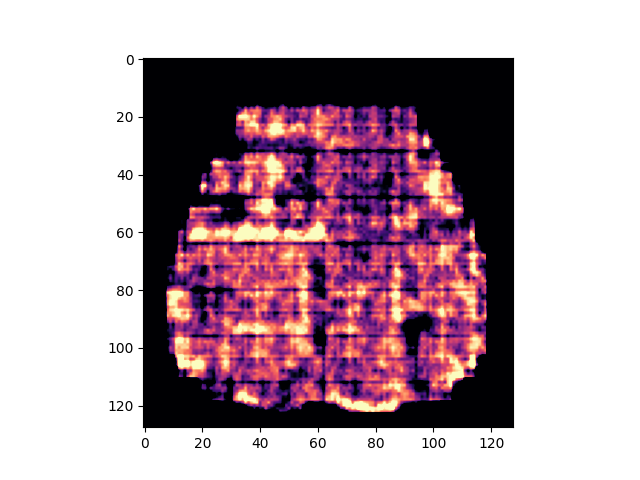

In [423]:
predictions = autoencoder.predict(outmat1[50,:,:].reshape([1,128,128,1],order='F'))
fig, ax = plt.subplots()
ax.imshow(predictions[0,:,:,0],vmin=-.1, vmax=.1, cmap = 'magma')
plt.show()

In [623]:
## SINDy for variable mappings

## Scaling
scale_x = MinMaxScaler(feature_range=(-1, 1))
scale_x.fit(xtrain.flatten().reshape(-1,1))
xx = scale_x.transform(xtrain.flatten().reshape(-1,1)).reshape(xtrain.shape)
xx = StandardScaler(with_std=False).fit_transform(xx)


scale_y = MinMaxScaler(feature_range=(-1, 1))
scale_y.fit(ytrain.flatten().reshape(-1,1))
yy = scale_y.transform(ytrain.flatten().reshape(-1,1)).reshape(ytrain.shape)
yy = StandardScaler(with_std=False).fit_transform(yy)

#lag = 10
#xx = xx[:-lag:]
#yy = yy[lag:,:]
xx = xx[701:,:]
yy = yy[701:,:]


poly_order=3
lib = ps.PolynomialLibrary(degree=poly_order).fit(xx)
#lib2 = ps.FourierLibrary(n_frequencies=1)#.fit(xx)
#lib = ps.GeneralizedLibrary([lib1,lib2]).fit(xx)
Xi = lib.transform(xx)
L = Lasso(alpha=.0001, max_iter=1000)
L.fit(Xi,yy[:,:])
ytrain_hat = L.predict(Xi)

r2_score(yy[:,:], ytrain_hat, multioutput='variance_weighted')
#print('score = ', L.score(Xi,ytrain))
#print('coefficients = \n', L.coef_)


0.837768695260241

<IPython.core.display.Javascript object>


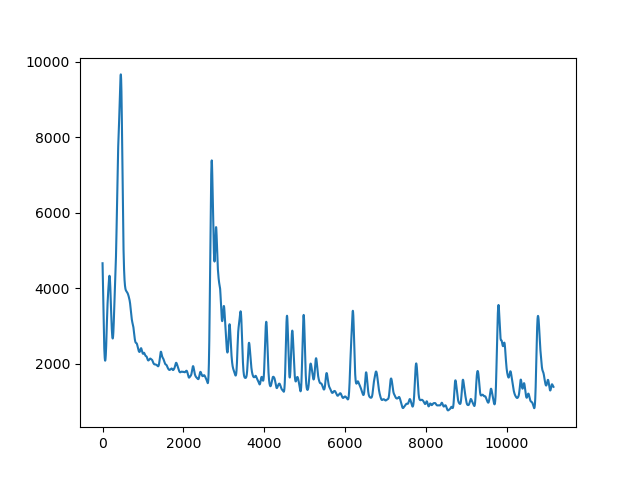

In [796]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
fig, ax = plt.subplots()
pf = PolynomialFeatures(degree=1)
Xp = pf.fit_transform(pupil)

md2 = LinearRegression()
md2.fit(Xp, pupil)
trendp = md2.predict(Xp)

#detrpoly = [pupil[i] - trendp[i] for i in range(0, len(pupil))]
detrpoly = pupil-trendp
plt.plot(detrpoly[:,0])
plt.show()

<IPython.core.display.Javascript object>


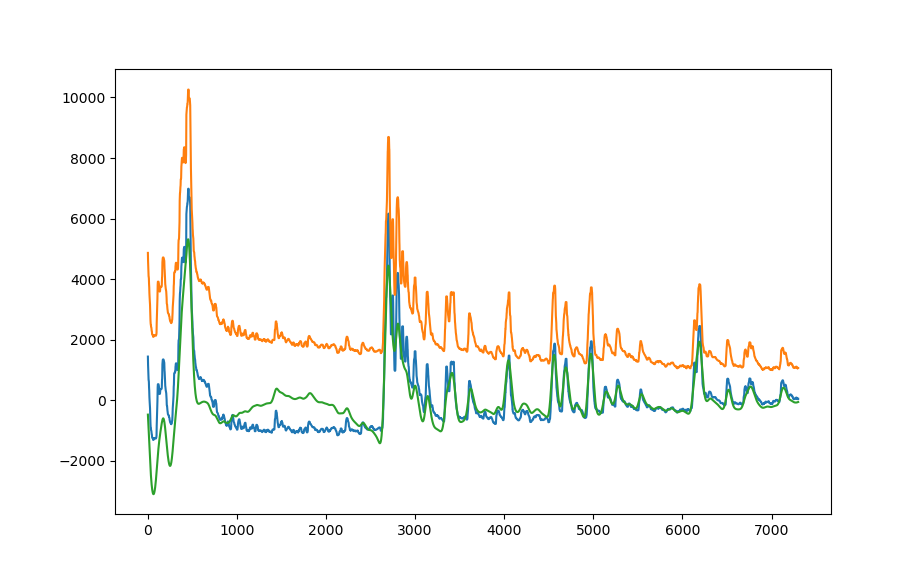

In [802]:
fig, ax = plt.subplots()
#plt.plot(-H[-1,:])
#plt.plot(-yy[:,0])
#plt.plot(-ytest_hat[:,0])

plt.plot(-xx[:,0])
plt.plot(-yy[:,0])
#plt.plot(signal.detrend(pupil[:7300],axis=0))
#plt.plot(pupil[:7300])
#plt.plot(pupil1[:7300])

<IPython.core.display.Javascript object>


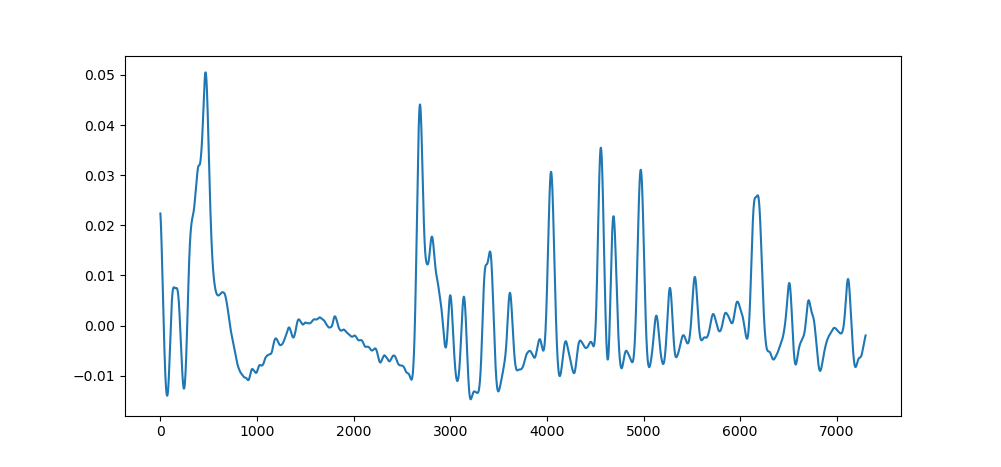

In [771]:
fig, ax = plt.subplots()
plt.plot(-u[700:,0])

<IPython.core.display.Javascript object>


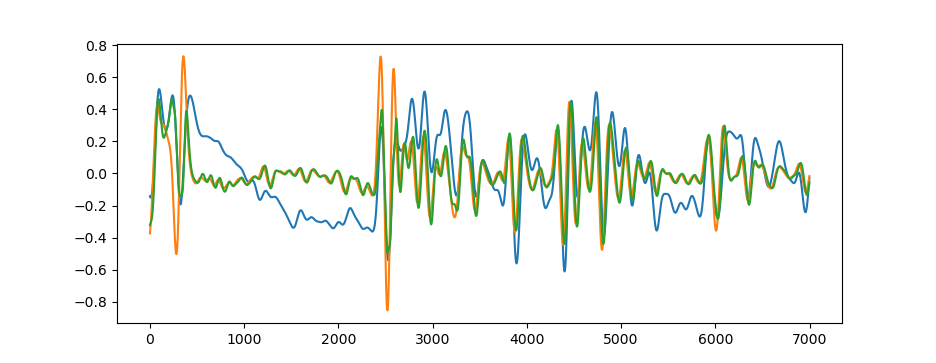

In [873]:
fig, ax = plt.subplots()
plt.plot(yy[:,2])
plt.plot(-xx[:,2])
plt.plot(ytrain_hat[:,2])
plt.show()

<IPython.core.display.Javascript object>


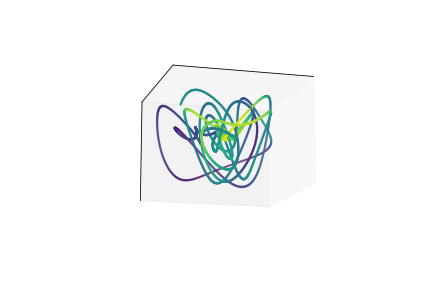

In [1583]:
# State space recon
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
#plt.plot(xtrain2[:,0],xtrain2[:,1],xtrain2[:,2])
#colors = np.arctan(xtrain[:,2],xtrain[:,1])
#colors = u[:-stackmax+1,1].reshape(-1,1)
colors = u[stackmax-1:,1].reshape(-1,1)
#colors = np.linspace(0,1,xtrain2.shape[0])
lim = 5000
ax.scatter(xtrain[:lim,1],xtrain[:lim,0],xtrain[:lim,2],s=2,c=colors[:lim],cmap='viridis')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
#ax.set_xticklabels([])
#ax.set_yticklabels([])
#ax.set_zticklabels([]0)
plt.show()

<IPython.core.display.Javascript object>


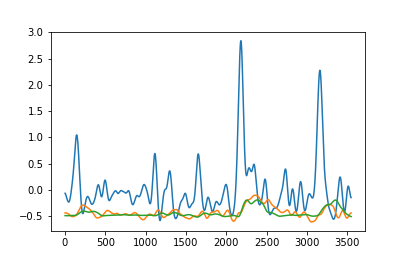

In [1625]:
fig, ax = plt.subplots()
#plt.plot(-xx[:,0])
plt.plot(-H[-1,:])
plt.plot(-yy[:,1])
plt.plot(-ytest_hat)

<IPython.core.display.Javascript object>


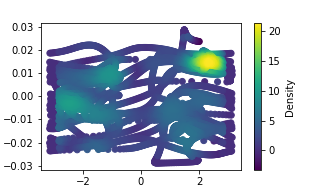

In [1442]:
from scipy.stats import gaussian_kde
#xy = np.vstack([np.arctan2(xtrain[:,1],xtrain[:,2]),u[:-stackmax+1,1].reshape(-1,1).transpose()])
#z = gaussian_kde(xy)(xy)

#plt.scatter(np.arctan2(xtrain[:,1],xtrain[:,2]),u[:-stackmax+1,1].reshape(-1,1),c=z,s=5)
ax = density_scatter(np.arctan2(xtrain[:,1],xtrain[:,2]),u[:-stackmax+1,1],bins=[10,10] )
plt.show()

In [1439]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn

def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    plt.scatter( x, y, c=z, **kwargs )

    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
    cbar.ax.set_ylabel('Density')

    return ax

<IPython.core.display.Javascript object>


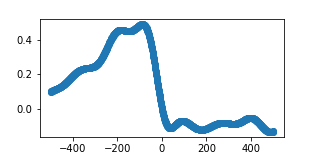

In [1398]:
fig, ax = plt.subplots()
plt.xcorr(x[:,0],x[:,1],maxlags=500,normed=True,usevlines=False)
plt.show()

In [624]:
## HELD OUT DATA

# Project
ytest = y[8000:,:]
ytest = ytest@vh[:10,:].transpose()

x = ytest[:,0].reshape(-1,1)
#x = StandardScaler(with_std=False).fit_transform(x)
H = hankel_matrix(x.transpose(),stackmax,spacing)
#Hu, Hs, Hvh = np.linalg.svd(H, full_matrices=False)
xtest = H.transpose()@Hu[:,:r]

#H = H.transpose()
#xtest = H
#xtest = Hvh[:10,:].transpose()
#xtest = np.concatenate((x.transpose()[:-spacing*(stackmax-1)],xtest*60),1)
#xtest.shape

#ytest = ytest[:-spacing*(stackmax-1),:]
ytest = ytest[stackmax-1:,:]

In [625]:
# SINDy validation test
xx = scale_x.transform(xtest.flatten().reshape(-1,1)).reshape(xtest.shape)
xx = StandardScaler(with_std=False).fit_transform(xx)
yy = scale_y.transform(ytest.flatten().reshape(-1,1)).reshape(ytest.shape)
yy = StandardScaler(with_std=False).fit_transform(yy)

#xx = xx[:-lag:]
#yy = yy[lag:,:]

#lib = ps.PolynomialLibrary(degree=poly_order).fit(xx)
Xi = lib.transform(xx)
#L.fit(Xi,yy[:,1])
ytest_hat = L.predict(Xi)
r2_score(yy[:,:], ytest_hat, multioutput='variance_weighted')

0.78111650534663

In [162]:
## Train neural net
model = Sequential()
model.add(Dense(10, input_dim=xtrain.shape[1], activation='tanh', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='tanh', kernel_initializer='he_uniform'))
#model.add(Dense(3, activation='tanh', kernel_initializer='he_uniform'))
#model.add(Dropout(.5))
model.add(Dense(10, activation='linear', kernel_initializer='he_uniform'))

#model.add(Dropout(.1))
# define the loss function and optimization algorithm
model.compile(loss='mse', optimizer='adam')
# ft the model on the training dataset
model.fit(xtrain, ytrain[:,:], epochs=1000, batch_size=500, verbose=1, validation_split=0.1)

Epoch 1/1000
15/15 [==============================] - 0s 10ms/step - loss: 0.0793 - val_loss: 0.0232
Epoch 2/1000
15/15 [==============================] - 0s 3ms/step - loss: 0.0785 - val_loss: 0.0228
Epoch 3/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0778 - val_loss: 0.0231
Epoch 4/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0772 - val_loss: 0.0229
Epoch 5/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0765 - val_loss: 0.0228
Epoch 6/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0759 - val_loss: 0.0225
Epoch 7/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0752 - val_loss: 0.0226
Epoch 8/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0745 - val_loss: 0.0224
Epoch 9/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0737 - val_loss: 0.0223
Epoch 10/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0729 - val_loss: 0.022

15/15 [==============================] - 0s 4ms/step - loss: 0.0342 - val_loss: 0.0232
Epoch 163/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0342 - val_loss: 0.0248
Epoch 164/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0342 - val_loss: 0.0244
Epoch 165/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0342 - val_loss: 0.0256
Epoch 166/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0343 - val_loss: 0.0235
Epoch 167/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0342 - val_loss: 0.0231
Epoch 168/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0342 - val_loss: 0.0235
Epoch 169/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0343 - val_loss: 0.0221
Epoch 170/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0343 - val_loss: 0.0235
Epoch 171/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0342 - val_loss: 0.

15/15 [==============================] - 0s 4ms/step - loss: 0.0335 - val_loss: 0.0234
Epoch 323/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0335 - val_loss: 0.0234
Epoch 324/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0334 - val_loss: 0.0241
Epoch 325/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0335 - val_loss: 0.0256
Epoch 326/1000
15/15 [==============================] - 0s 5ms/step - loss: 0.0335 - val_loss: 0.0258
Epoch 327/1000
15/15 [==============================] - 0s 5ms/step - loss: 0.0335 - val_loss: 0.0245
Epoch 328/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0334 - val_loss: 0.0233
Epoch 329/1000
15/15 [==============================] - 0s 5ms/step - loss: 0.0334 - val_loss: 0.0233
Epoch 330/1000
15/15 [==============================] - 0s 5ms/step - loss: 0.0334 - val_loss: 0.0246
Epoch 331/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0334 - val_loss: 0.

15/15 [==============================] - 0s 4ms/step - loss: 0.0317 - val_loss: 0.0257
Epoch 483/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0317 - val_loss: 0.0244
Epoch 484/1000
15/15 [==============================] - 0s 5ms/step - loss: 0.0317 - val_loss: 0.0245
Epoch 485/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0317 - val_loss: 0.0270
Epoch 486/1000
15/15 [==============================] - 0s 5ms/step - loss: 0.0317 - val_loss: 0.0268
Epoch 487/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0316 - val_loss: 0.0247
Epoch 488/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0316 - val_loss: 0.0233
Epoch 489/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0316 - val_loss: 0.0260
Epoch 490/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0315 - val_loss: 0.0246
Epoch 491/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0316 - val_loss: 0.

15/15 [==============================] - 0s 4ms/step - loss: 0.0282 - val_loss: 0.0267
Epoch 643/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0281 - val_loss: 0.0264
Epoch 644/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0281 - val_loss: 0.0249
Epoch 645/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0281 - val_loss: 0.0249
Epoch 646/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0281 - val_loss: 0.0249
Epoch 647/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0281 - val_loss: 0.0253
Epoch 648/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0280 - val_loss: 0.0256
Epoch 649/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0281 - val_loss: 0.0252
Epoch 650/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0280 - val_loss: 0.0258
Epoch 651/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0280 - val_loss: 0.

15/15 [==============================] - 0s 4ms/step - loss: 0.0261 - val_loss: 0.0253
Epoch 803/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0261 - val_loss: 0.0254
Epoch 804/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0261 - val_loss: 0.0258
Epoch 805/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0260 - val_loss: 0.0260
Epoch 806/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0260 - val_loss: 0.0269
Epoch 807/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0261 - val_loss: 0.0255
Epoch 808/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0260 - val_loss: 0.0259
Epoch 809/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0260 - val_loss: 0.0265
Epoch 810/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0260 - val_loss: 0.0246
Epoch 811/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0260 - val_loss: 0.

15/15 [==============================] - 0s 4ms/step - loss: 0.0244 - val_loss: 0.0247
Epoch 963/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0245 - val_loss: 0.0251
Epoch 964/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0244 - val_loss: 0.0259
Epoch 965/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0245 - val_loss: 0.0253
Epoch 966/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0244 - val_loss: 0.0259
Epoch 967/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0244 - val_loss: 0.0255
Epoch 968/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0244 - val_loss: 0.0269
Epoch 969/1000
15/15 [==============================] - 0s 5ms/step - loss: 0.0244 - val_loss: 0.0256
Epoch 970/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0244 - val_loss: 0.0255
Epoch 971/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0244 - val_loss: 0.

In [ ]:
model.fit(xtrain, ytrain[:,:], epochs=1000, batch_size=500, verbose=1, validation_split=0.1)

In [163]:
## Predict input data
ytrain_hat = model.predict(xtrain)

# inverse transforms
#x_plot = scale_x.inverse_transform(x)
#y_plot = scale_y.inverse_transform(y)
#yhat_plot = scale_y.inverse_transform(yhat)

# report model error
#print('MSE: %.3f' % mean_squared_error(ytrain[:,:], ytrain_hat))
r2_score(ytrain[:,:], ytrain_hat, multioutput='variance_weighted')

0.6653776924947736

In [8]:
# Compare to variance explained by PCA
u, s, vh = np.linalg.svd(y, full_matrices=False)

<IPython.core.display.Javascript object>


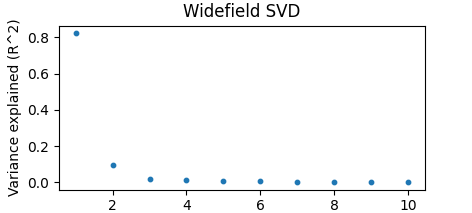

In [590]:
import matplotlib.ticker as mticker
fig, ax = plt.subplots()
plt.scatter(np.arange(1,11),(s[:10]**2)/np.sum(s**2),10)
#plt.scatter(np.arange(1,11),(Hs[:10]**2)/np.sum(Hs**2),10)
ax.set_xlabel("Component #")
ax.set_ylabel("Variance explained (R^2)")
ax.set_title("Widefield SVD")

#plt.yscale('log')
#ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
#ax.xaxis.get_major_formatter().set_scientific(False)
#ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.4f'))
#ax.yaxis.get_major_formatter().set_useOffset(False)

plt.show()

<IPython.core.display.Javascript object>


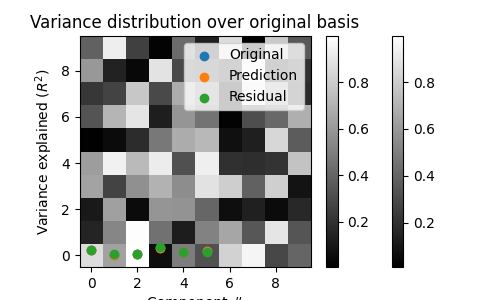

In [103]:
fig, ax = plt.subplots(figsize=(5,3))
energies = np.var(yy,axis=0)/np.sum(np.var(yy,axis=0))
plt.scatter(np.arange(0,n),energies,label='Original')
energies2 = np.var(ytest_hat,axis=0)/np.sum(np.var(ytest_hat,axis=0))
plt.scatter(np.arange(0,n),energies2,label='Prediction')

yresid = yy-ytest_hat
energies3 = np.var(yresid,axis=0)/np.sum(np.var(yresid,axis=0))
plt.scatter(np.arange(0,n),energies3,label='Residual')

ax.set_xlabel("Component #")
ax.set_ylabel("Variance explained ($R^2$)")
ax.set_title("Variance distribution over original basis")

ax.legend(loc="upper right")

plt.show()

In [102]:
np.arange(1,n).shape

(5,)

In [398]:
dmd_basis = np.concatenate((dmd.modes[:,:int(n/2)].real,dmd.modes[:,:int(n/2)].imag),axis=1).transpose()

In [402]:
yfull = y[-yy.shape[0]-lag:-lag,:]
yfull_scaled = scale_y.transform(yfull.flatten().reshape(-1,1)).reshape(yfull.shape)
yfull_scaled = StandardScaler(with_std=False).fit_transform(yfull_scaled)


r2_score(yfull_scaled, yy@vh[:n,:], multioutput='variance_weighted')
#r2_score(yfull_scaled, yy@dmd_basis, multioutput='variance_weighted')
#r2_score(yfull_scaled@vh[:n,:].transpose(), yy, multioutput='variance_weighted')

-3.7252971036771445

In [403]:
r2_score(yfull_scaled, ytest_hat@vh[:n,:], multioutput='variance_weighted')

-3.4720048467739586

In [1822]:
stats.pearsonr(ytest[:,2],ytest_hat[:,2])

(0.4738962230741144, 3.103148911180648e-198)

In [1663]:
## HELD OUT DATA

# Project
ytest = y[8000:,:]
ytest = ytest@vh[:10,:].transpose()
x = ytest[:,0].reshape(-1,1)
H = hankel_matrix(x.transpose(),stackmax,spacing)
xtest = H.transpose()@Hu[:,:r]
ytest = ytest[stackmax-1:,:]

In [1673]:
## Predict held-out data
ytest_hat = model.predict(xtest)
r2_score(ytest[:,1], ytest_hat)#, multioutput='variance_weighted')

-0.06451355765424327

In [3]:
# load mask
#raichle_dir = '/mnt/raichle/ryan/mouse'
mask = io.loadmat(data_dir+'/newmask.mat')
mask = mask["newmask"]
mask.dtype = bool
mask_long = mask.reshape(16384,order='F')

In [6]:
# insert data
data = y

outmat = np.zeros((data.shape[0],16384), dtype=np.single)

# project back
#outmat[:,mask_long] = data@vh[:10,:]
outmat[:,mask_long] = y
c = .01
outmat[:,~mask_long] = -c
outmat = outmat.reshape(data.shape[0],128,128,order='F')

<IPython.core.display.Javascript object>


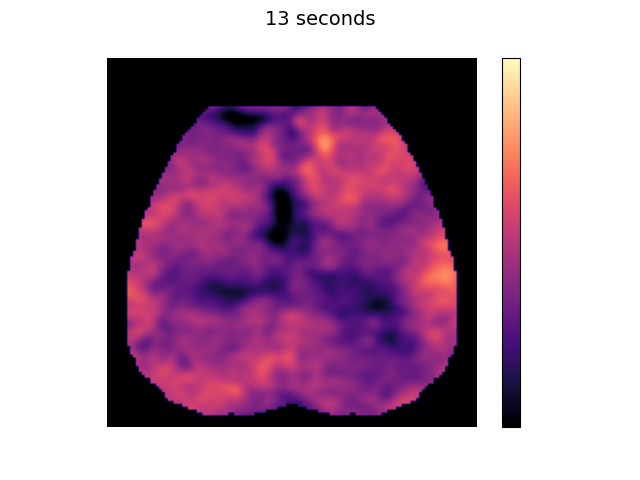

In [28]:
# MOVIE
## animate
c = .01

#%matplotlib qt
fig = plt.figure()

#fig, (ax1, ax2) = plt.subplots(2,1)
im = plt.imshow(outmat[0,:,:], animated=True, vmin=-c, vmax=c, cmap = 'magma')
#plt.title('Recon')
cbar = plt.colorbar()
cbar.set_ticks([])
plt.axis('off')

i = 0
def update(*args):
    global i
    if (i<outmat.shape[0]):
        i += 1
    else:
        i=0
    im.set_array(outmat[i,:,:])
    fig.suptitle(str(np.ceil(i*.05).astype(int)) + ' seconds', fontsize=14)


    return im,

ani = FuncAnimation(fig, update, blit=True, interval = 5, frames=10000)

In [25]:
f = 'test1.mp4'
writervideo = FFMpegWriter(fps=20)
ani.save(f, writer=writervideo)

In [20]:
from IPython.display import Video
#ffmpeg -i test.mp4 video.mp4 
#Video('200715-1-fc1_labeled.mp4',embed=True, width=128, height=128)
#Video('test.mp4')
Video('/mnt/raichle/ryan/mouse/movies/recon_pupil_test_filt0p1_lagged1.mp4')

ValueError: To embed videos, you must pass embed=True (this may make your notebook files huge)
Consider passing Video(url='...')

In [27]:
from ipywidgets import Output, GridspecLayout
from IPython import display

filepaths = ['test.mp4','test1.mp4']
grid = GridspecLayout(1,len(filepaths))

for i, filepath in enumerate(filepaths):
    out = Output()
    with out:
        if i==0:
            display.display(display.Video(filepath, embed=False, width=400, height=400))
        else:
            display.display(display.Video(filepath, embed=True, width=500, height=500))
    grid[0,i] = out

grid

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

## RECON MOVIE

<IPython.core.display.Javascript object>


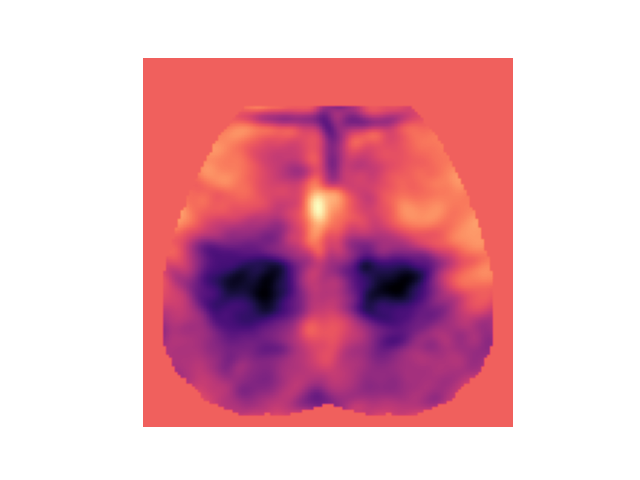

(-0.5, 127.5, 127.5, -0.5)

In [383]:
# visualize components

comp = 4

temp = np.zeros((16384,1), dtype=np.single)
#temp[mask_long] = vh[comp,:].reshape(-1,1)
#temp[~mask_long] = np.min(vh[comp,:])
temp[mask_long] = dmd.modes[:,comp].real.reshape(-1,1)
temp = temp.reshape(128,128,order='F')

fig, ax = plt.subplots()
im = ax.imshow(temp, cmap = 'magma')
ax.axis('off')


In [396]:
#### SIDE BY SIDE

# insert data
#data1 = ytrain[700:,:]
#data1 = ytrain
#data2 = ytrain_hat

#ytest = Hb[:n,nsamples:].transpose()
#data1 = ytest[:-lag,:]
data1 = yy
data2 = ytest_hat

data1 = StandardScaler(with_std=False).fit_transform(data1)
data2 = StandardScaler(with_std=False).fit_transform(data2)

outmat1 = np.zeros((data1.shape[0],16384), dtype=np.single)
outmat2 = np.zeros((data2.shape[0],16384), dtype=np.single)

# project back
outmat1[:,mask_long] = data1@vh[:n,:]
#outmat1[:,mask_long] = y[7800:-stackmax+1,:] ### if learned on delayed widefield
#outmat1[:,mask_long] = y[7800+spacing*(stackmax-1):-lag,:] ### if learned on real-time widefield with lag
#outmat1[:,mask_long] = y[nsamples+800+stackmax-1:,:] ### if learned on real-time widefield
outmat2[:,mask_long] = data2@vh[:n,:]
#outmat2[:,mask_long] = decoder.predict(data2)


# dmd modes
outmat1[:,mask_long] = data1@np.concatenate((dmd.modes[:,:int(n/2)].real,dmd.modes[:,:int(n/2)].imag),axis=1).transpose()
outmat2[:,mask_long] = data2@np.concatenate((dmd.modes[:,:int(n/2)].real,dmd.modes[:,:int(n/2)].imag),axis=1).transpose()
#outmat2[:,mask_long] = data2@dmd.modes[:,:n].real.transpose()


#c1 = .01
c1 = 1
c2 = 1
outmat1[:,~mask_long] = -c1
outmat1 = outmat1.reshape(data1.shape[0],128,128,order='F')
outmat2[:,~mask_long] = -c2
outmat2 = outmat2.reshape(data2.shape[0],128,128,order='F')

<IPython.core.display.Javascript object>


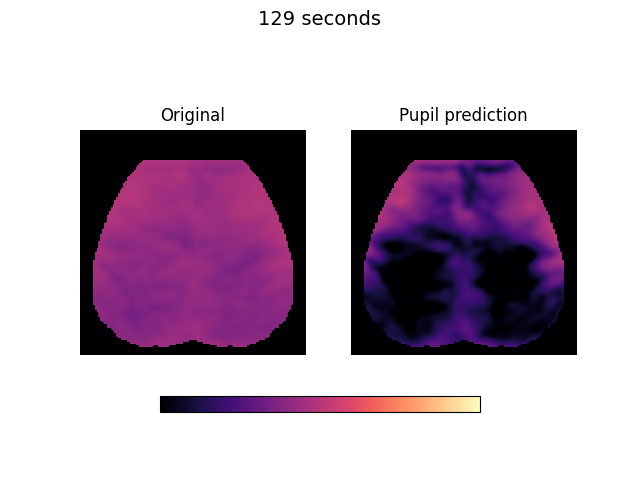

In [397]:
# MOVIE
## animate

c1 = .01#/2
c2 = c1/2
#c1 = c1*30 #for orig

# %matplotlib qt
fig, (ax1, ax2) = plt.subplots(1,2)
im1 = ax1.imshow(outmat1[0,:,:], animated=True, vmin=-c1, vmax=c1, cmap = 'magma')
im2 = ax2.imshow(outmat2[0,:,:], animated=True, vmin=-c2, vmax=c2, cmap = 'magma')

ax1.axis('off')
ax2.axis('off')

cbar_ax = fig.add_axes([.25,.1,.5,.5])
cbar_ax.axis('off')
cbar = fig.colorbar(im1,ax=cbar_ax,orientation = "horizontal")
cbar.set_ticks([])


i = 0
def update(*args):
    global i
    if (i<outmat1.shape[0]):
        i += 1
    else:
        i=0
    im1.set_array(outmat1[i,:,:])
    im2.set_array(outmat2[i,:,:])
    ax1.title.set_text('Original')
    ax2.title.set_text('Pupil prediction')
    fig.suptitle(str(np.ceil(i*.05).astype(int)) + ' seconds', fontsize=14)

    return im1, im2,

ani = FuncAnimation(fig, update, blit=True, interval = 5, frames=3000) #5,3000

plt.show()

In [1502]:
temp = np.zeros(yy.shape[0])
for i in range(yy.shape[0]):
    [temp[i],p] = stats.pearsonr(yy[i,:].transpose(),ytest_hat[i,:].transpose())

<IPython.core.display.Javascript object>


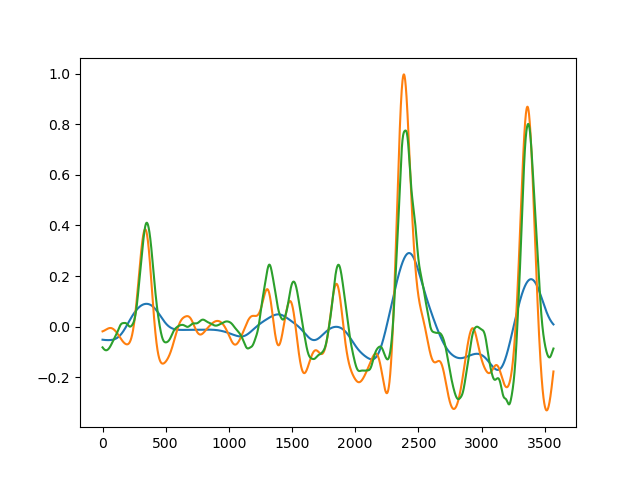

In [1591]:
fig, ax = plt.subplots()
#plt.plot(temp)
plt.plot(-xx[:,0])
plt.plot(-yy[:,0])
plt.plot(-ytest_hat[:,0])
plt.show()

In [773]:
#f = '/mnt/raichle/ryan/mouse/movies/DUBH_recon_pupil_test_filt0p1_lagged1.mp4'
f = 'recon_pupil_hpfilt_lagged1.mp4'
writervideo = FFMpegWriter(fps=60)
ani.save(f, writer=writervideo)

In [1709]:
## VARIANCE EXPLAINED ON ORIGINAL DATA
#r2_score(y[:8000,:],(((vh[:10,:]@y[:8000,:].transpose())).transpose())@ vh[:10,:], multioutput='variance_weighted')
#r2_score(y[:8000,:],y[:8000,:]@(vh[:10,:].transpose() @ vh[:10,:]), multioutput='variance_weighted')
r2_score(y[:8000,:],u[:8000,:10]@u[:8000,:10].transpose()@y[:8000,:], multioutput='variance_weighted')

#r2_score(y[:8000,:],ytrain@vh[:10,:], multioutput='variance_weighted')

#r2_score(y[:8000,:], ytrain_hat@vh[:10,:], multioutput='variance_weighted')

In [115]:
### NOW WITH PUPIL
#pupil = np.load(raichle_dir+'/../latent_dynamics/pupil1.npy')
#pupil = signal.medfilt(pupil,[15,1])
pupil = signal.sosfiltfilt(sos,pupil,axis = 0)

In [612]:
#stackmax = 200
#spacing = 1
#r = 20

H = hankel_matrix(pupil.transpose(),stackmax,spacing)
Hu, Hs, Hvh = np.linalg.svd(H, full_matrices=False)
xtrain = Hvh[:r,:ytrain.shape[0]].transpose()
#xtrain = H[701:ytrain.shape[0]+1,:3] #741, +41


In [509]:
#plt.plot(ytrain[:,0])
#plt.plot(xtrain[:,0]*.001)
xtrain = np.concatenate((.00001*pupil[701:ytrain.shape[0]+1],xtrain),1) #741,+41
#xtrain*=.001
xtrain*=10
xtrain.shape

(7151, 6)

In [510]:
## Train neural net
model = Sequential()
model.add(Dense(3, input_dim=xtrain.shape[1], activation='tanh', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='linear', kernel_initializer='he_uniform'))
#model.add(Dropout(.1))
# define the loss function and optimization algorithm
model.compile(loss='mse', optimizer='adam')
# ft the model on the training dataset
model.fit(xtrain, ytrain[700:,:], epochs=1000, batch_size=500, verbose=1)

Epoch 1/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0864
Epoch 2/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0821
Epoch 3/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0794
Epoch 4/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0775
Epoch 5/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0761
Epoch 6/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0747
Epoch 7/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0735
Epoch 8/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0723
Epoch 9/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0712
Epoch 10/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0701
Epoch 11/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0691
Epoch 12/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0681
Epoch 13/1000
15/15 [====

15/15 [==============================] - 0s 1ms/step - loss: 0.0373
Epoch 102/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.0373
Epoch 103/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.0373
Epoch 104/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.0373
Epoch 105/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0373
Epoch 106/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0373
Epoch 107/1000
15/15 [==============================] - 0s 3ms/step - loss: 0.0373
Epoch 108/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0373
Epoch 109/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0372
Epoch 110/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0372
Epoch 111/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0372
Epoch 112/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0372
Epoch 113/1000
15/1

15/15 [==============================] - 0s 1ms/step - loss: 0.0364
Epoch 298/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.0364
Epoch 299/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0364
Epoch 300/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0364
Epoch 301/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0364
Epoch 302/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0364
Epoch 303/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0364
Epoch 304/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0364
Epoch 305/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0364
Epoch 306/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0364
Epoch 307/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0364
Epoch 308/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0364
Epoch 309/1000
15/1

15/15 [==============================] - 0s 3ms/step - loss: 0.0354
Epoch 494/1000
15/15 [==============================] - 0s 3ms/step - loss: 0.0354
Epoch 495/1000
15/15 [==============================] - 0s 3ms/step - loss: 0.0354
Epoch 496/1000
15/15 [==============================] - 0s 3ms/step - loss: 0.0354
Epoch 497/1000
15/15 [==============================] - 0s 3ms/step - loss: 0.0354
Epoch 498/1000
15/15 [==============================] - 0s 3ms/step - loss: 0.0354
Epoch 499/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0354
Epoch 500/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0354
Epoch 501/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0354
Epoch 502/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0354
Epoch 503/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0354
Epoch 504/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0354
Epoch 505/1000
15/1

15/15 [==============================] - 0s 2ms/step - loss: 0.0348
Epoch 690/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0348
Epoch 691/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0348
Epoch 692/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0348
Epoch 693/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0348
Epoch 694/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0348
Epoch 695/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0348
Epoch 696/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0348
Epoch 697/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0348
Epoch 698/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0348
Epoch 699/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0347
Epoch 700/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0347
Epoch 701/1000
15/1

15/15 [==============================] - 0s 2ms/step - loss: 0.0336
Epoch 886/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0336
Epoch 887/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0336
Epoch 888/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0336
Epoch 889/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0336
Epoch 890/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0336
Epoch 891/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0336
Epoch 892/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0335
Epoch 893/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0335
Epoch 894/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0335
Epoch 895/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0335
Epoch 896/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0335
Epoch 897/1000
15/1

In [468]:
model.fit(xtrain, ytrain[700:,:], epochs=1000, batch_size=500, verbose=1)

Epoch 1/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.0319
Epoch 2/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0319
Epoch 3/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0319
Epoch 4/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0319
Epoch 5/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0319
Epoch 6/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0319
Epoch 7/1000
15/15 [==============================] - 0s 3ms/step - loss: 0.0319
Epoch 8/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0319
Epoch 9/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0319
Epoch 10/1000
15/15 [==============================] - 0s 3ms/step - loss: 0.0319
Epoch 11/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0319
Epoch 12/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0319
Epoch 13/1000
15/15 [====

15/15 [==============================] - 0s 2ms/step - loss: 0.0317
Epoch 102/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0317
Epoch 103/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0317
Epoch 104/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0317
Epoch 105/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0317
Epoch 106/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0317
Epoch 107/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0317
Epoch 108/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0317
Epoch 109/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.0317
Epoch 110/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.0317
Epoch 111/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.0317
Epoch 112/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0317
Epoch 113/1000
15/1

15/15 [==============================] - 0s 2ms/step - loss: 0.0315
Epoch 298/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0315
Epoch 299/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.0315
Epoch 300/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.0315
Epoch 301/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.0315
Epoch 302/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.0315
Epoch 303/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.0315
Epoch 304/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.0315
Epoch 305/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.0315
Epoch 306/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.0315
Epoch 307/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0315
Epoch 308/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.0315
Epoch 309/1000
15/1

15/15 [==============================] - 0s 3ms/step - loss: 0.0314
Epoch 494/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0314
Epoch 495/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0314
Epoch 496/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0314
Epoch 497/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0314
Epoch 498/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0314
Epoch 499/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0314
Epoch 500/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0314
Epoch 501/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0314
Epoch 502/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0314
Epoch 503/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0314
Epoch 504/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0314
Epoch 505/1000
15/1

15/15 [==============================] - 0s 2ms/step - loss: 0.0313
Epoch 690/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0313
Epoch 691/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0313
Epoch 692/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0313
Epoch 693/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0313
Epoch 694/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0313
Epoch 695/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0313
Epoch 696/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0313
Epoch 697/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0313
Epoch 698/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0313
Epoch 699/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0313
Epoch 700/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.0313
Epoch 701/1000
15/1

KeyboardInterrupt: 

In [511]:
## Predict input data
ytrain_hat = model.predict(xtrain)
print('MSE: %.3f' % mean_squared_error(ytrain[700:,:], ytrain_hat))
r2_score(ytrain[700:,:], ytrain_hat, multioutput='variance_weighted')

MSE: 0.033


0.5345031966590065

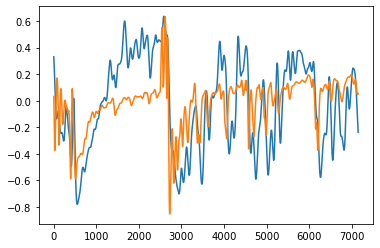

In [459]:
%matplotlib inline
fig, ax = plt.subplots()
plt.plot(ytrain[700:,1])
plt.plot(ytrain_hat[:,1])
#plt.plot(xtrain[:,1])
plt.show()

In [450]:
#stats.pearsonr(ytrain[700:,0],ytrain_hat[:,0])
stats.pearsonr(ytrain[:,0],pupil[0:ytrain.shape[0],0])

(-0.5722140158894836, 0.0)

In [614]:
## HELD OUT DATA

# Project
#ytest = y[8000:,:]
#ytest = ytest@vh[:10,:].transpose()
#ytest = ytest[:-stackmax,:] #-41

#xtest = H[8001:,:3] #8041
xtest = Hvh[:r,8000:].transpose()
#xtest = np.concatenate((.00001*pupil[8001:-stackmax+1],xtest),1) #8041
#xtest*=10
xtest.shape


(3700, 10)

In [363]:
xtest.shape

(3659, 3)

In [513]:
## Predict held-out data
ytest_hat = model.predict(xtest)

# report model error
print('MSE: %.3f' % mean_squared_error(ytest,ytest_hat))
r2_score(ytest, ytest_hat, multioutput='variance_weighted')

MSE: 0.027


0.2789250577516546

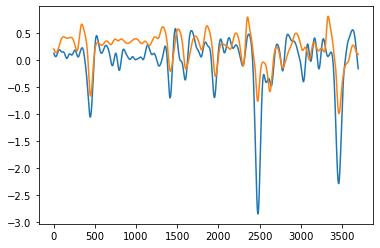

In [453]:
%matplotlib inline
fig, ax = plt.subplots()
plt.plot(ytest[:,0])
plt.plot(ytest_hat[:,0])
plt.show()

In [1]:
stats.pearsonr(ytest[:,0],xtest[:,0])

NameError: name 'stats' is not defined

## VARIABLE TRANSFORMS

In [5]:
import pysindy as ps
from sklearn.linear_model import LinearRegression, Lasso, LassoCV

In [145]:
dt = .05
#t = np.arange(0, y.shape[0], dt)
#tspan = (t[0],t_train[-1])
thresholds = .1 * np.ones((10,2))
thresholds[:,1] = .02
sr3_optimizer = ps.SR3(thresholder="weighted_l0", thresholds=thresholds)

# LASSO
lasso_optimizer = Lasso(alpha=.004, max_iter=2000, fit_intercept=False)

# Instantiate and fit the SINDy model
model = ps.SINDy(
    #optimizer=ps.STLSQ(threshold=.2),
    #optimizer=sr3_optimizer,
    optimizer=lasso_optimizer,
    #differentiation_method=ps.SmoothedFiniteDifference(drop_endpoints=True),
    feature_library=ps.PolynomialLibrary(degree=3),
    #feature_names=["PC1", "PC2"]
)
model.fit(-ytrain[:,:2], t=dt)
model.print()

(x0)' = -0.175 x1 + -0.139 x0 x1
(x1)' = 0.079 x0 + -0.010 x0^3


In [146]:
dt = .05
t = np.arange(0, PC1.size, dt)
x0 = -ytrain[1000,:2]
x_sim = model.simulate(x0, t)

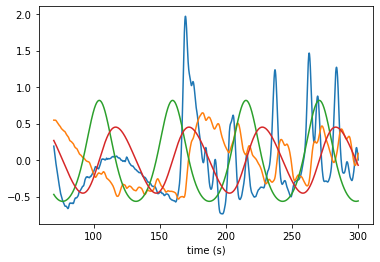

In [149]:
fig, ax = plt.subplots()
plt.plot(t[1400:6000],-ytrain[1400:6000,:2])
plt.plot(t[1400:6000],x_sim[400:5000,:])
plt.xlabel("time (s)")
plt.show()

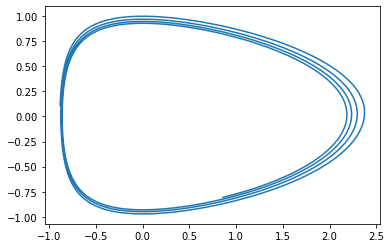

In [144]:
# Plot attractor
#fig = plt.figure()
#ax = fig.add_subplot(projection='3d')
plt.plot(x_sim[:5000,0],x_sim[:5000,1])
plt.show()

In [4]:
poly_order=5
X, names = sindy_library(svd_data.x, i, include_names=True, include_sine=False)
Y = data.z

L = Lasso(alpha=1e-5, fit_intercept=False)
L.fit(X, Y)
z_pred = L.predict(X)

print('degree = ', poly_order)
print('score = ', L.score(X, Y))
print('coefficients = \n', L.coef_)

In [557]:
#PC1 = ytrain[:,0].reshape(-1,1)
#PC2 = ytrain[:,1].reshape(-1,1)

uu = u[:,:2]
sos = signal.butter(2, .08, output = 'sos', fs = 20)
#uu = signal.sosfiltfilt(sos, uu, axis = 0)

x = (uu[:,0]*s[0]).reshape(-1,1).transpose()
stackmax = 200
spacing = 2
H = hankel_matrix(x,stackmax,spacing)
Hu, Hs, Hvh = np.linalg.svd(H, full_matrices=False)
H = H.transpose()
xtrain = Hvh[:6,:].transpose()
xtrain = np.concatenate((x.transpose()[:-spacing*(stackmax-1)],xtrain*60),1)

PC1 = xtrain
PC2 = (uu[:PC1.shape[0],1]*s[1]).reshape(-1,1)
poly_order=4
lib = ps.PolynomialLibrary(degree=poly_order).fit(PC1)
Xi = lib.transform(PC1)
L = Lasso(alpha=.001, fit_intercept=True)
L.fit(Xi,PC2)
PC2_hat = L.predict(Xi)

print('score = ', L.score(Xi,PC2))
#print('coefficients = \n', L.coef_)
PC2.shape

score =  0.745461286145514


/home/ryraut/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.218e+01, tolerance: 8.880e-02
  model = cd_fast.enet_coordinate_descent(


(7602, 1)

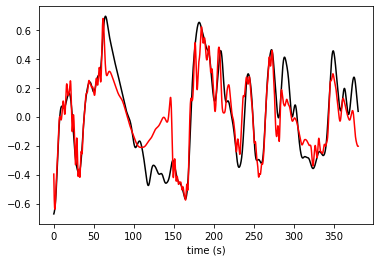

In [230]:
%matplotlib inline

dt = .05
t = np.arange(0,PC2.size*dt, dt)

fig, ax = plt.subplots()
plt.plot(t,-PC2,'k')
plt.plot(t,-PC2_hat,'r')
plt.xlabel("time (s)")
plt.show()

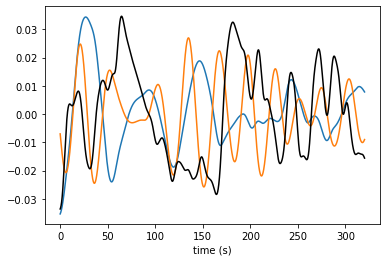

In [115]:
%matplotlib inline

dt = .05
t = np.arange(0,PC1.shape[0]*dt, dt)

fig, ax = plt.subplots()
plt.plot(t,-PC1[:,1])
plt.plot(t,-PC1[:,2])
plt.plot(t,-.05*PC2,'k')
plt.xlabel("time (s)")
plt.show()

<IPython.core.display.Javascript object>


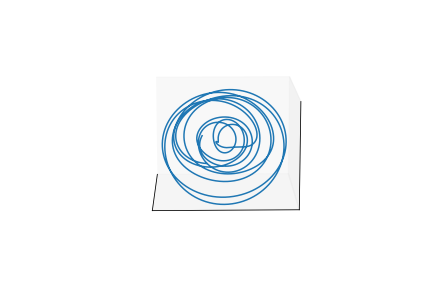

In [116]:
# Plot attractor
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
lim = 5000
plt.plot(-PC1[:,1],-PC1[:,2],-PC1[:,3])
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.show()

In [559]:
## TEST ON HELDOUT SINDY

# Project
ytest = y[:,:]
ytest = ytest@vh[:10,:].transpose()

uu = ytest[:,:2]
#sos = signal.butter(2, .08, output = 'sos', fs = 20)
#uu = signal.sosfiltfilt(sos, uu, axis = 0)

x = (uu[:,0]).reshape(-1,1).transpose()
H = hankel_matrix(x,stackmax,spacing)
Hu, Hs, Hvh = np.linalg.svd(H, full_matrices=False)
H = H.transpose()
xtest = Hvh[:6,:].transpose()
xtest = np.concatenate((x.transpose()[:-spacing*(stackmax-1)],xtest*60),1)

PC1 = xtest
PC2 = (uu[:PC1.shape[0],1]).reshape(-1,1)
poly_order=4
lib = ps.PolynomialLibrary(degree=poly_order).fit(PC1)
Xi = lib.transform(PC1)

PC2_hat = L.predict(Xi)

print('score = ', L.score(Xi,PC2))
r2_score(PC2, PC2_hat)#, multioutput='variance_weighted')

score =  0.45529415939639883


0.45529415939639883

<IPython.core.display.Javascript object>


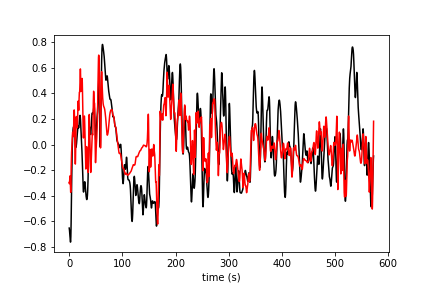

In [242]:
%matplotlib notebook

dt = .05
t = np.arange(0,PC2.size*dt, dt)

fig, ax = plt.subplots()
plt.plot(t,-PC2,'k')
plt.plot(t,-PC2_hat,'r')
#plt.plot(t,-PC1[:,0],'b')
#plt.plot(t,(.71*PC1[:,0]**2 -.10*PC1[:,0]**4) + PC1[:,0],'r')
plt.xlabel("time (s)")
plt.show()

In [2057]:
###################
# VAE AUTOENCODER

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## encoder
latent_dim = 2
encoder_inputs = keras.Input(shape=(128,128, 1))
x = layers.Conv2D(32, 3, activation="tanh", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="tanh", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="tanh")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

## decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(32 * 32 * 64, activation="tanh")(latent_inputs)
x = layers.Reshape((32, 32, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="tanh", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="tanh", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="tanh", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


## VAE
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mse(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_44 (InputLayer)          [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_76 (Conv2D)             (None, 64, 64, 32)   320         ['input_44[0][0]']               
                                                                                                  
 conv2d_77 (Conv2D)             (None, 32, 32, 64)   18496       ['conv2d_76[0][0]']              
                                                                                                  
 flatten_8 (Flatten)            (None, 65536)        0           ['conv2d_77[0][0]']        

In [2082]:
## FITTING
vae = VAE(encoder, decoder)
vae.compile(optimizer='adam')
vae.fit(outmat1[:100,:,:].reshape([100,128,128,1],order='F'), epochs=30, batch_size=500)

Epoch 1/30


2022-06-18 12:57:07.808460: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1048576000 exceeds 10% of free system memory.
2022-06-18 12:57:21.659264: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1048576000 exceeds 10% of free system memory.


KeyboardInterrupt: 

In [2068]:
def plot_latent_space(vae, n=5, figsize=10):
    # display a n*n 2D manifold of digits
    digit_size = 128
    scale = 1
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, vmin=-.01, vmax=.01, cmap='magma')
    plt.show()


<IPython.core.display.Javascript object>


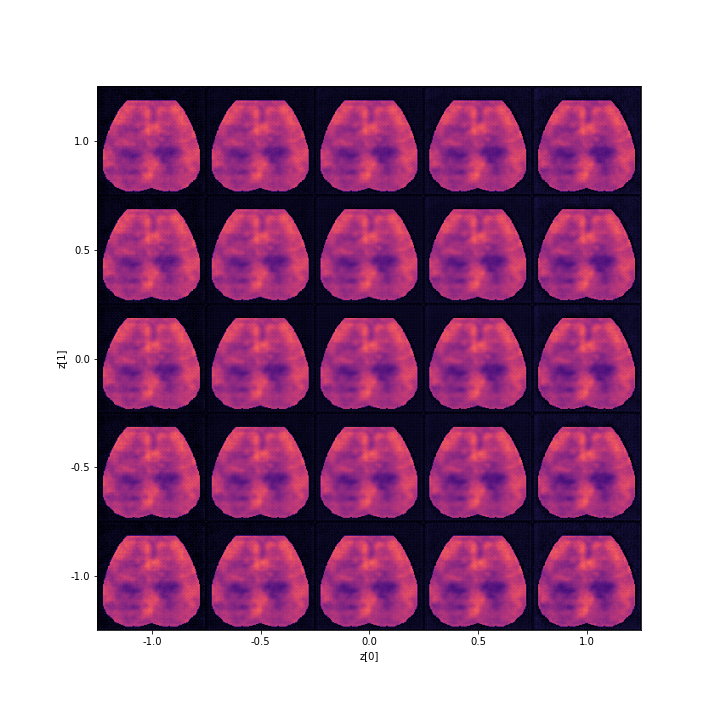

In [2069]:
plot_latent_space(vae)

In [2079]:
[t1,t2,t3] = vae.encoder.predict(outmat1[5,:,:].reshape([1,128,128,1]))
temp = vae.decoder.predict(t3)

<IPython.core.display.Javascript object>


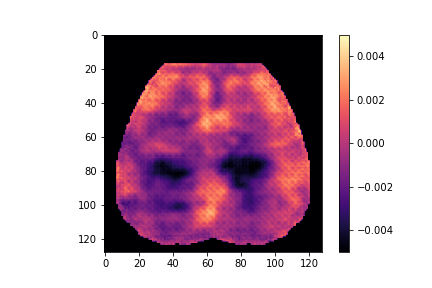

In [2080]:
fig, ax = plt.subplots()
im = ax.imshow(temp[0,:,:,0], cmap='magma', vmin=-.005, vmax=.005)
plt.colorbar(im)
plt.show()

In [2135]:
def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

class KLDivergenceLayer(layers.Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs


input_dim = 10400
intermediate_dim = 100
latent_dim = 2

x = keras.Input(shape=(input_dim,))
h = Dense(intermediate_dim, activation='tanh')(x)

z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
z_sigma = layers.Lambda(lambda t: K.exp(.5*t))(z_log_var)

eps = keras.Input(tensor=K.random_normal(shape=(K.shape(x)[0], latent_dim)))
z_eps = layers.Multiply()([z_sigma, eps])
z = layers.Add()([z_mu, z_eps])

decoder = Sequential([
    Dense(intermediate_dim, input_dim=latent_dim, activation='tanh'),
    Dense(original_dim, activation='tanh')
])

x_pred = decoder(z)

vae = Model(inputs=[x, eps], outputs=x_pred)
vae.compile(optimizer='rmsprop', loss=nll)

vae.summary()

Model: "model_35"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_73 (InputLayer)          [(None, 10400)]      0           []                               
                                                                                                  
 dense_189 (Dense)              (None, 100)          1040100     ['input_73[0][0]']               
                                                                                                  
 dense_190 (Dense)              (None, 2)            202         ['dense_189[0][0]']              
                                                                                                  
 dense_191 (Dense)              (None, 2)            202         ['dense_189[0][0]']              
                                                                                           

In [ ]:
vae.fit(y[:10,:],
        y[:10,:],
        shuffle=True,
        epochs=50,
        batch_size=100
        #validation_data=(y[-10,:].reshape(-1,input_dim), y[-10,:].reshape(-1,input_dim))
       )

In [370]:
from pydmd import DMD
dmd = DMD(svd_rank=10)
dmd.fit(y[:4000,:].T)

/home/ryraut/miniconda3/envs/swdb2022/lib/python3.8/site-packages/pydmd/dmdbase.py:715: UserWarning: Input data matrix X has condition number 7.595234429242798e+17. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


In [355]:
dmd.modes.shape

(10400, 10)

# Predict WF

In [4]:
### NOW WITH PUPIL

#whisker
#raichle_dir = '/mnt/raichle/ryan/mouse'
#pupil = np.load(raichle_dir+'/../latent_dynamics/pupil1.npy')

Fs = 20
pupil = np.load('pupil1.npy')
pupil = pupil[800:]
sos = signal.butter(2, [.01,.2],btype = 'bandpass', output = 'sos', fs = Fs)
#sos = signal.butter(2, .01, btype = 'high', output = 'sos', fs = 20)
#sos = signal.butter(2, .2, output = 'sos', fs = 20)
pupil = signal.sosfiltfilt(sos,pupil,axis = 0)

In [57]:
from numpy import genfromtxt
face = genfromtxt(data_dir + '/200715-1-fc1_OpticalFlow_Magnitudes.csv', delimiter=',')
face = face[800:pupil.size+800]
#face = signal.sosfiltfilt(sos,face,axis = 0)
face = face.reshape(-1,1)

In [ ]:
def multiscale_hankel(Xin, n_delay_coordinates, spacing1 = 2, spacing=1):
    n_inputs, n_samples = Xin.shape

    X = np.zeros((n_inputs * (n_delay_coordinates), n_samples - spacing*(n_delay_coordinates-1)))
    for i in range(n_delay_coordinates):
        idxs = np.arange(spacing1*i, spacing*(i+1) + n_samples - spacing*n_delay_coordinates)
        X[i*n_inputs:(i+1)*n_inputs] = Xin[:, idxs]
    return X

In [407]:
## DELAY EMBED
stackmax = 100
spacing = 4
n = 10
r = 6
nsamples = 6000

Hp = hankel_matrix(pupil.transpose(),stackmax,spacing)
#Hp = multiscale_hankel(pupil.transpose(),stackmax,2)
Hpu, Hps, Hpvh = np.linalg.svd(Hp, full_matrices=False)

#x = u[:,:n]*s[:n]
#yproj = y[800:,:]@dmd.modes[:,:int(n/2)].real
#yproj = np.concatenate((yproj, y[800:,:]@dmd.modes[:,:int(n/2)].imag), axis=1)
yproj = y[800:,:]@vh[:n,:].transpose()
#yproj = y[800:,:]
#yproj = encoder.predict(y[800:,:])

# alpha power
#yproj = np.abs(signal.hilbert(yproj))
sos = signal.butter(2, [.01,.2],btype = 'bandpass', output = 'sos', fs = 20)
#sos = signal.butter(2, .01, btype = 'high', output = 'sos', fs = 20)
yproj = signal.sosfiltfilt(sos,yproj,axis = 0)

#Hb = hankel_matrix(yproj.transpose(),stackmax,spacing) ## ONLY EXCLUDE FOR NO HANKELIZING BRAIN
#Hbu, Hbs, Hbvh = np.linalg.svd(Hb, full_matrices=False) ## ONLY FOR HANKEL SVD OF BRAIN

#xtrain = Hp[:,nsamples:].transpose() # full Hankel
xtrain = Hpvh[:r,:nsamples].transpose()
#ytrain = Hbvh[:r,:nsamples].transpose()
ytrain = yproj[spacing*(stackmax+1):nsamples+spacing*(stackmax+1),:] ## USE FOR NO HANKELIZING OF BRAIN


#ytrain = Hb[:,:nsamples].transpose()@np.matlib.repmat(Hpu[:,:r],n,1)
#ytrain = Hb[:,:nsamples].transpose()@np.kron(Hpu[:,:r],np.ones((n,1))) ## USE TO PROJECT BRAIN ONTO PUPIL HANKEL

In [408]:
## SINDy for variable mappings

## Scaling
scale_x = MinMaxScaler(feature_range=(-1, 1))
scale_x.fit(xtrain.flatten().reshape(-1,1))
xx = scale_x.transform(xtrain.flatten().reshape(-1,1)).reshape(xtrain.shape)
xx = StandardScaler(with_std=False).fit_transform(xx)


scale_y = MinMaxScaler(feature_range=(-1, 1))
scale_y.fit(ytrain.flatten().reshape(-1,1))
yy = scale_y.transform(ytrain.flatten().reshape(-1,1)).reshape(ytrain.shape)
yy = StandardScaler(with_std=False).fit_transform(yy)

lag = 1 # in seconds
lag = lag*Fs*spacing
#xx = xx[:-lag:]
#yy = yy[lag:,:]

xx = xx[lag:]
yy = yy[:-lag,:]


poly_order=3
lib = ps.PolynomialLibrary(degree=poly_order).fit(xx)
#lib2 = ps.FourierLibrary(n_frequencies=1)#.fit(xx)
#lib = ps.GeneralizedLibrary([lib,lib2]).fit(xx)
Xi = lib.transform(xx)
L = Lasso(alpha=.0001, max_iter=1000) #alpha=.0001 for projection onto pupil hankel basis
#L = BaggingRegressor(base_estimator=L, n_estimators=20, max_samples=1.0, random_state=0)
L.fit(Xi,yy)

ytrain_hat = L.predict(Xi)
r2_score(yy[:,:], ytrain_hat, multioutput='variance_weighted')


0.845325052416875

In [147]:
## RRR

## Scaling
scale_x = MinMaxScaler(feature_range=(-1, 1))
scale_x.fit(xtrain.flatten().reshape(-1,1))
xx = scale_x.transform(xtrain.flatten().reshape(-1,1)).reshape(xtrain.shape)
xx = StandardScaler(with_std=False).fit_transform(xx)


scale_y = MinMaxScaler(feature_range=(-1, 1))
scale_y.fit(ytrain.flatten().reshape(-1,1))
yy = scale_y.transform(ytrain.flatten().reshape(-1,1)).reshape(ytrain.shape)
yy = StandardScaler(with_std=False).fit_transform(yy)

lag = 1 # in seconds
lag = lag*Fs*spacing
#xx = xx[:-lag:]
#yy = yy[lag:,:]

xx = xx[lag:]
yy = yy[:-lag,:]


poly_order=3
lib = ps.PolynomialLibrary(degree=poly_order).fit(xx)
Xi = lib.transform(xx)

In [152]:
from sklearn.cross_decomposition import PLSRegression, CCA
#pls = PLSRegression(n_components=30)
#pls.fit(Xi, yy)
ytrain_hat = pls.predict(Xi)

r2_score(yy, ytrain_hat, multioutput='variance_weighted')

0.7134739885719419

In [409]:
# HELD OUT DATA
nsamples = 6000
nsamples = nsamples + 1000
xtest = Hpvh[:r,nsamples:].transpose()
#ytest = Hbvh[:r,7000:].transpose()
ytest = yproj[nsamples+spacing*(stackmax-1):,:] #works


#ytest = Hb[:,nsamples:].transpose()@np.matlib.repmat(Hpu[:,:r],n,1)
#ytest = Hb[:,nsamples:].transpose()@np.kron(Hpu[:,:r],np.ones((n,1)))


In [410]:
# SINDy validation test
xx = scale_x.transform(xtest.flatten().reshape(-1,1)).reshape(xtest.shape)
xx = StandardScaler(with_std=False).fit_transform(xx)
yy = scale_y.transform(ytest.flatten().reshape(-1,1)).reshape(ytest.shape)
yy = StandardScaler(with_std=False).fit_transform(yy)

xx = xx[lag:]
yy = yy[:-lag,:]

Xi = lib.transform(xx)
ytest_hat = L.predict(Xi)
r2_score(yy[:,:],ytest_hat, multioutput='variance_weighted')

0.7563387919012929

In [392]:
## NEW PUT BACK ON BRAIN
#yy = np.matlib.repmat(Hpu[:,:r],n,1)@yy.transpose()
#ytest_hat = np.matlib.repmat(Hpu[:,:r],n,1)@ytest_hat.transpose()

yy = np.kron(Hpu[:,:r],np.ones((n,1)))@yy.transpose()
ytest_hat = np.kron(Hpu[:,:r],np.ones((n,1)))@ytest_hat.transpose()

yy = yy[:n,:].transpose()
ytest_hat = ytest_hat[:n,:].transpose()

In [393]:
# project from brain hankel (I think)
#ytest = Hb[:n,nsamples:].transpose()
#ytest_hat = Hbu[:,:r]@np.diag(Hbs[:r])@ytest_hat[:,:r].transpose()
#ytest_hat = ytest_hat[:n,:].transpose()

In [394]:
#ytest = StandardScaler(with_std=True).fit_transform(ytest)
#ytest_hat = StandardScaler(with_std=True).fit_transform(ytest_hat)
#r2_score(ytest[:-lag,:],ytest_hat, multioutput='variance_weighted')
r2_score(yy,ytest_hat, multioutput='variance_weighted')
#ytest_hat = yy-ytest_hat

0.6089071656213645

In [153]:
yy = yy@pls.y_weights_
ytest_hat = ytrain_hat@pls.y_weights_

<IPython.core.display.Javascript object>


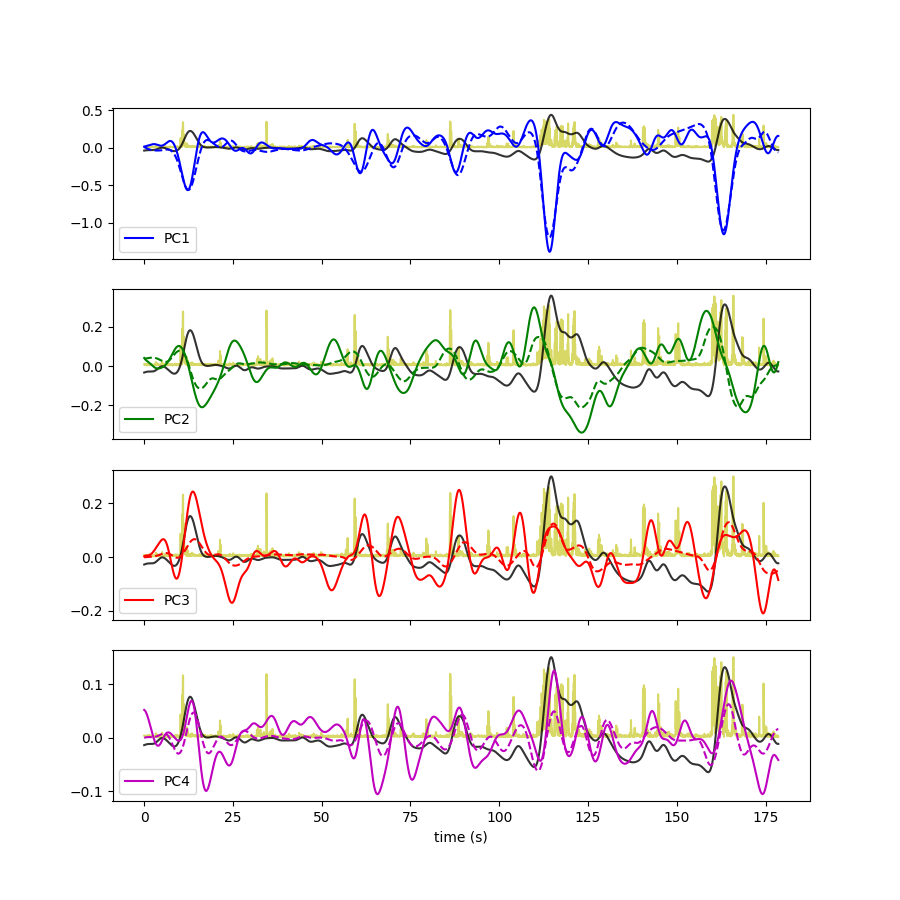

In [411]:
## PC DYNAMICS

plt.style.use("default")

fig, axes = plt.subplots(4,1,sharex='col',figsize=(9,9))

dt = .05
t = np.arange(0,yy.shape[0]*dt,dt)
plt.xlabel("time (s)")

pupil_plot = pupil[-yy.shape[0]-lag:-lag]
pupil_plot = (1/np.max(pupil_plot))*pupil_plot

face_plot = face[-yy.shape[0]-lag:-lag]
face_plot = (1/np.max(face_plot))*face_plot

labels = ["PC1", "PC2", "PC3", "PC4"]

ax = 0
axes[ax].plot(t,1.2*np.max(yy[:,ax])*face_plot,'y',alpha=.6)
axes[ax].plot(t,1.2*np.max(yy[:,ax])*pupil_plot,'k',alpha=.8)
axes[ax].plot(t,yy[:,ax],'b',label=labels[ax])
axes[ax].plot(t,ytest_hat[:,ax],'b',linestyle='dashed',alpha=1)
axes[ax].legend(loc="lower left")
    
ax = 1
axes[ax].plot(t,1.2*np.max(yy[:,ax])*face_plot,'y',alpha=.6)
axes[ax].plot(t,1.2*np.max(yy[:,ax])*pupil_plot,'k',alpha=.8)
axes[ax].plot(t,yy[:,1],'g',label=labels[ax])
axes[ax].plot(t,ytest_hat[:,ax],'g',linestyle='dashed')
axes[ax].legend(loc="lower left")

ax = 2
axes[ax].plot(t,1.2*np.max(yy[:,ax])*face_plot,'y',alpha=.6)
axes[ax].plot(t,1.2*np.max(yy[:,ax])*pupil_plot,'k',alpha=.8)
axes[ax].plot(t,yy[:,2],'r',label=labels[ax])
axes[ax].plot(t,ytest_hat[:,ax],'r',linestyle='dashed')
axes[ax].legend(loc="lower left")

ax = 3
axes[ax].plot(t,1.2*np.max(yy[:,ax])*face_plot,'y',alpha=.6)
axes[ax].plot(t,1.2*np.max(yy[:,ax])*pupil_plot,'k',alpha=.8)
axes[ax].plot(t,yy[:,3],'m',label=labels[ax])
axes[ax].plot(t,ytest_hat[:,ax],'m',linestyle='dashed')
axes[ax].legend(loc="lower left")

#plt.suptitle('Widefield reconstructions from pupil size')
plt.show()

#colors = ["r","g","b"]
#for i,ax in enumerate(axes):
#  axs[i].plot([0,1],[1,0],color=colors[i]

In [421]:
colors = np.zeros((yy.shape[0],1))
for i in range(lim):
    colors[i],a = stats.pearsonr(vh[0,:].transpose(),(ytest_hat[i,:]@vh[:n,:]).transpose())
    #colors[i],a = stats.pearsonr(vh[1,:].transpose(),(ytest_hat[i,:]@pls.y_weights_.transpose()).transpose())

In [501]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=8, random_state=0).fit(ytest)
colors = kmeans.labels_

<IPython.core.display.Javascript object>


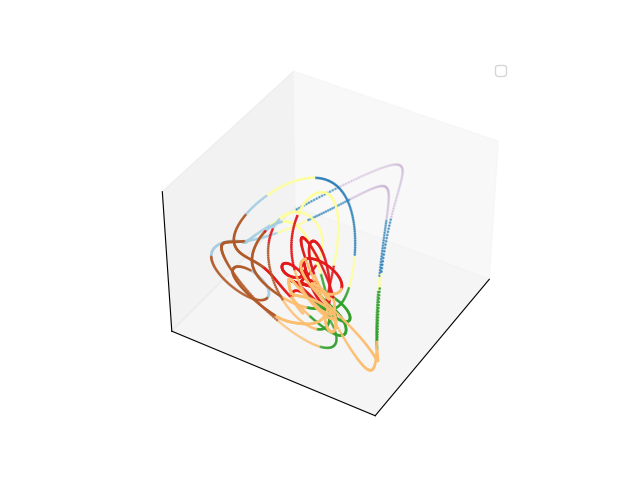

In [505]:
plt.style.use("default")


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
lim = yy.shape[0]
utest = yy
#utest,stest,vtest = np.linalg.svd(ytest_hat)
#colors = np.arange(0,lim)
ax.scatter(utest[:lim,0],utest[:lim,1],utest[:lim,2],s=1,c=colors[:lim],cmap='Paired')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
#plt.axis('off')

ax.view_init(39,31) #0,1,2 view
#ax.view_init(31,39) #0,1,3 view
1
#ax.xaxis.pane.set_facecolor('w')
#ax.yaxis.pane.set_facecolor('w')
#ax.zaxis.pane.set_facecolor('w')

plt.show()



<IPython.core.display.Javascript object>


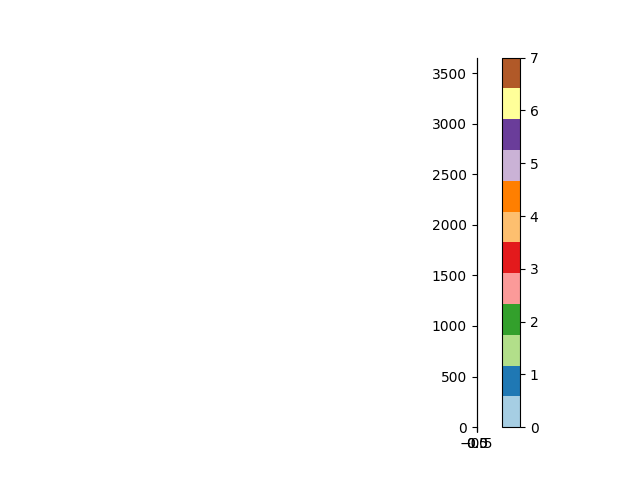

In [511]:
fig,ax = plt.subplots()
plt.imshow(colors.reshape(-1,1), cmap='Paired')
plt.colorbar()
plt.show()

In [334]:
## SINDy
dt = .05
#t = np.arange(0, y.shape[0], dt)
#tspan = (t[0],t_train[-1])

# LASSO
lasso_optimizer = Lasso(alpha=.001, max_iter=1000, fit_intercept=True)

# Instantiate and fit the SINDy model
model = ps.SINDy(
    optimizer=lasso_optimizer,
    feature_library=ps.PolynomialLibrary(degree=3),
)
model.fit(xx[:,:3], t=dt)
model.print()


(x0)' = -0.135 x1 + -0.001
(x1)' = 0.170 x0 + -0.142 x2 + -0.001
(x2)' = 0.172 x1 + -0.001


In [ ]:
dt = .05
t = np.arange(0, xx.shape[0], dt)
x0 = xx[200,:3]
x_sim = model.simulate(x0, t)

fig, ax = plt.subplots()
plt.plot(t[:100],x_sim[:100,:3])
plt.xlabel("time (s)")
plt.show()

<IPython.core.display.Javascript object>


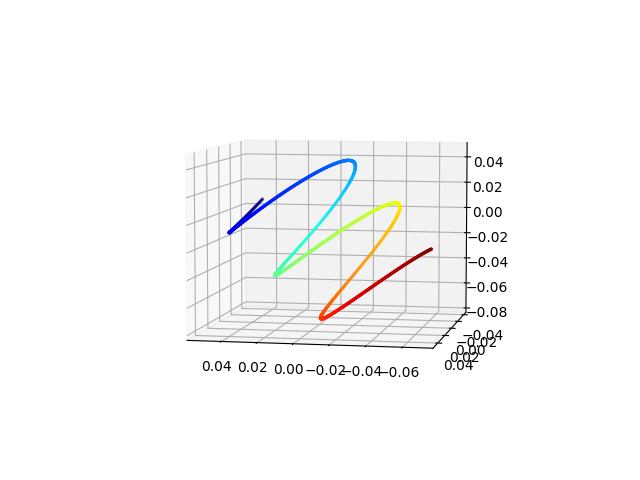

In [289]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
lim = 1500
colors = np.arange(0,lim)
ax.scatter(x_sim[:lim,0],x_sim[:lim,1],x_sim[:lim,2],s=2,c=colors[:lim],cmap='jet')

plt.show()

<IPython.core.display.Javascript object>


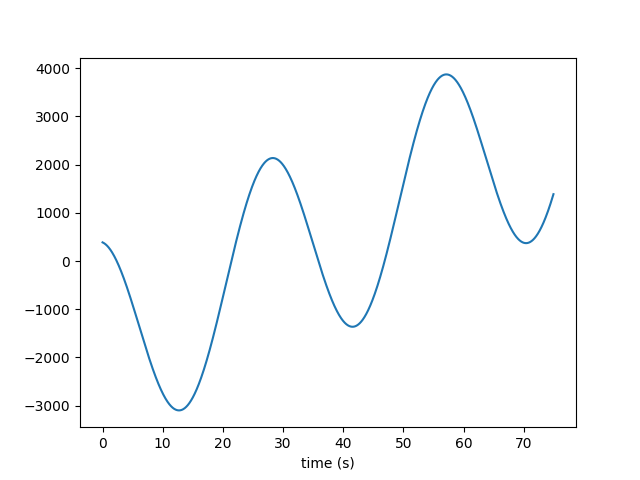

In [294]:
# Reconstruct pupil size from latent dynamics
fig, ax = plt.subplots()
temp = Hpu[:,:3]@np.diag(Hps[:3])@x_sim[:1500,:3].transpose()
plt.plot(t[:1500],temp[0,:])
plt.xlabel("time (s)")
plt.show()

In [493]:
## Train neural net
out_dim = n
model = Sequential()
model.add(Dense(out_dim+2, input_dim=xx.shape[1], activation='tanh', kernel_initializer='he_uniform'))
model.add(Dense(out_dim, activation='tanh', kernel_initializer='he_uniform'))
#model.add(Dense(5, activation='tanh', kernel_initializer='he_uniform'))
#model.add(Dense(5, activation='tanh', kernel_initializer='he_uniform'))
model.add(Dense(out_dim, activation='linear', kernel_initializer='he_uniform'))

#model.add(Dropout(.1))
# define the loss function and optimization algorithm
model.compile(loss='mse', optimizer='adam')
# ft the model on the training dataset
model.fit(xx, yy, epochs=1000, batch_size=500, verbose=1, validation_split=0)

Epoch 1/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.1652
Epoch 2/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.1368
Epoch 3/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.1140
Epoch 4/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0958
Epoch 5/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0810
Epoch 6/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0689
Epoch 7/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0590
Epoch 8/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0510
Epoch 9/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0443
Epoch 10/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0388
Epoch 11/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0342
Epoch 12/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0303
Epoch 13/1000
12/12 [====

12/12 [==============================] - 0s 2ms/step - loss: 0.0068
Epoch 102/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0067
Epoch 103/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0067
Epoch 104/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0067
Epoch 105/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0067
Epoch 106/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0067
Epoch 107/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0066
Epoch 108/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0066
Epoch 109/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0066
Epoch 110/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0066
Epoch 111/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0066
Epoch 112/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0065
Epoch 113/1000
12/1

12/12 [==============================] - 0s 9ms/step - loss: 0.0049
Epoch 200/1000
12/12 [==============================] - 0s 8ms/step - loss: 0.0049
Epoch 201/1000
12/12 [==============================] - 0s 9ms/step - loss: 0.0048
Epoch 202/1000
12/12 [==============================] - 0s 8ms/step - loss: 0.0048
Epoch 203/1000
12/12 [==============================] - 0s 7ms/step - loss: 0.0048
Epoch 204/1000
12/12 [==============================] - 0s 9ms/step - loss: 0.0048
Epoch 205/1000
12/12 [==============================] - 0s 8ms/step - loss: 0.0048
Epoch 206/1000
12/12 [==============================] - 0s 8ms/step - loss: 0.0048
Epoch 207/1000
12/12 [==============================] - 0s 7ms/step - loss: 0.0048
Epoch 208/1000
12/12 [==============================] - 0s 6ms/step - loss: 0.0047
Epoch 209/1000
12/12 [==============================] - 0s 7ms/step - loss: 0.0047
Epoch 210/1000
12/12 [==============================] - 0s 6ms/step - loss: 0.0047
Epoch 211/1000
12/1

12/12 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 298/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 299/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 300/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 301/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 302/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 303/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 304/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 305/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 306/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 307/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 308/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0040
Epoch 309/1000
12/1

12/12 [==============================] - 0s 2ms/step - loss: 0.0037
Epoch 396/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0037
Epoch 397/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0037
Epoch 398/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0037
Epoch 399/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0037
Epoch 400/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0037
Epoch 401/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 402/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0037
Epoch 403/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0037
Epoch 404/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0037
Epoch 405/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0037
Epoch 406/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0037
Epoch 407/1000
12/1

12/12 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch 494/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 495/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch 496/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch 497/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch 498/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch 499/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 500/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch 501/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch 502/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch 503/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch 504/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch 505/1000
12/1

12/12 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 592/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 593/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 594/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 595/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 596/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 597/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 598/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 599/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 600/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 601/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 602/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 603/1000
12/1

12/12 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 690/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 691/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 692/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 693/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 694/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 695/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 696/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 697/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 698/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 699/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 700/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 701/1000
12/1

12/12 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 788/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 789/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 790/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 791/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 792/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 793/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 794/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 795/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 796/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 797/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 798/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 799/1000
12/1

12/12 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch 886/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch 887/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch 888/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch 889/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch 890/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch 891/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 892/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch 893/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch 894/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 895/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 896/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 897/1000
12/1

12/12 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 984/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 985/1000
12/12 [==============================] - 0s 7ms/step - loss: 0.0023
Epoch 986/1000
12/12 [==============================] - 0s 6ms/step - loss: 0.0023
Epoch 987/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 988/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 989/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 990/1000
12/12 [==============================] - 0s 6ms/step - loss: 0.0023
Epoch 991/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 992/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 993/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 994/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 995/1000
12/1

In [497]:
model.fit(xx, yy, epochs=1000, batch_size=500, verbose=1, validation_split=0.0)

Epoch 1/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 2/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 3/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 4/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 5/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 6/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 7/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 8/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 9/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 10/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 11/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 12/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 13/1000
12/12 [====

12/12 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 102/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 103/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0021
Epoch 104/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0022
Epoch 105/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0021
Epoch 106/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 107/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0021
Epoch 108/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0021
Epoch 109/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0021
Epoch 110/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0021
Epoch 111/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0021
Epoch 112/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 113/1000
12/1

12/12 [==============================] - 0s 6ms/step - loss: 0.0020
Epoch 200/1000
12/12 [==============================] - 0s 6ms/step - loss: 0.0020
Epoch 201/1000
12/12 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 202/1000
12/12 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 203/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 204/1000
12/12 [==============================] - 0s 6ms/step - loss: 0.0020
Epoch 205/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 206/1000
12/12 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 207/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 208/1000
12/12 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 209/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 210/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 211/1000
12/1

12/12 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 298/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 299/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 300/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 301/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 302/1000
12/12 [==============================] - 0s 6ms/step - loss: 0.0020
Epoch 303/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 304/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 305/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 306/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 307/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 308/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 309/1000
12/1

12/12 [==============================] - 0s 3ms/step - loss: 0.0019
Epoch 396/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 397/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 398/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 399/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 400/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 401/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 402/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 403/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0019
Epoch 404/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0019
Epoch 405/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 406/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 407/1000
12/1

12/12 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 494/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 495/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0019
Epoch 496/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 497/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 498/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 499/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 500/1000
12/12 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 501/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 502/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 503/1000
12/12 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 504/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 505/1000
12/1

12/12 [==============================] - 0s 3ms/step - loss: 0.0019
Epoch 592/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0019
Epoch 593/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0019
Epoch 594/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0019
Epoch 595/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0019
Epoch 596/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 597/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 598/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 599/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 600/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 601/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0019
Epoch 602/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 603/1000
12/1

12/12 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 690/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 691/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 692/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 693/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 694/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 695/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 696/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 697/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 698/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 699/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 700/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 701/1000
12/1

12/12 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 788/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 789/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 790/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 791/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 792/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 793/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 794/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 795/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 796/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 797/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 798/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 799/1000
12/1

12/12 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 886/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 887/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 888/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 889/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 890/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 891/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 892/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 893/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 894/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 895/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 896/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 897/1000
12/1

12/12 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 984/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 985/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 986/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 987/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 988/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 989/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 990/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 991/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 992/1000
12/12 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 993/1000
12/12 [==============================] - 0s 6ms/step - loss: 0.0018
Epoch 994/1000
12/12 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 995/1000
12/1

In [498]:
xx = scale_x.transform(xtrain.flatten().reshape(-1,1)).reshape(xtrain.shape)
xx = StandardScaler(with_std=False).fit_transform(xx)
yy = scale_y.transform(ytrain.flatten().reshape(-1,1)).reshape(ytrain.shape)
yy = StandardScaler(with_std=False).fit_transform(yy)

xx = xx[lag:]
yy = yy[:-lag:,:]

r2_score(yy, model.predict(xx), multioutput='variance_weighted')

185/185 [==============================] - 0s 977us/step


0.9187791130373535

In [499]:
xx = scale_x.transform(xtest.flatten().reshape(-1,1)).reshape(xtest.shape)
xx = StandardScaler(with_std=False).fit_transform(xx)
yy = scale_y.transform(ytest.flatten().reshape(-1,1)).reshape(ytest.shape)
yy = StandardScaler(with_std=False).fit_transform(yy)

xx = xx[lag:]
yy = yy[:-lag:,:]

ytest_hat = model.predict(xx)
r2_score(yy, ytest_hat, multioutput='variance_weighted')

112/112 [==============================] - 0s 1ms/step


0.5496834808697421

## DEEP REGRESSION

In [190]:
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

def baseline_model():
	model = Sequential()
	model.add(Dense(10, input_dim=xx.shape[1], kernel_initializer='he_uniform', activation='tanh'))
	model.add(Dense(n, kernel_initializer='normal'))
	# Compile model
	model.compile(loss='mean_squared_error', optimizer='adam')
	return model

# evaluate model with standardized dataset
estimators = []
estimators.append(('mlp', KerasRegressor(model=baseline_model, epochs=200, batch_size=50, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=3)
results = cross_val_score(pipeline, xx, yy, cv=kfold, scoring='neg_mean_squared_error')
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Standardized: -0.01 (0.01) MSE


#### COMMON Z

In [ ]:


##
aInput = keras.Input(shape=(r,))
z = Dense(encoding_dim, activation='tanh')(aInput)
decodedA = Dense(r, activation='tanh')(z)

encoderA = keras.Model(aInput,z)
decoderA = keras.Model(z,decodedA)

bInput = keras.Input(shape=(r,))
z = Dense(encoding_dim, activation='tanh')(bInput)
decodedB = Dense(r, activation='tanh')(z)

encoderB = keras.Model(bInput,encodedb)
decoderB = keras.Model(encodedB,decodedB)


## VAE
class commonZ(keras.Model):
    def __init__(self, encoderA, decoderA, encoderB, decoderB, **kwargs):
        super(commonZ, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mse(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


def my_loss_fn(y_true1, y_pred1, y_true2, y_pred2):
    squared_difference = tf.square(y_true1 - y_pred1) + tf.square(y_true1 - y_pred1)
    return tf.reduce_mean(squared_difference, axis=-1)  # Note the `axis=-1`





input_dim = 10400
encoding_dim = n
input_data = keras.Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='tanh')(input_data)
decoded = Dense(input_dim, activation='tanh')(encoded)

autoencoder = keras.Model(input_data, decoded)
autoencoder.compile(optimizer='adam', loss=my_loss_fn)

encoder = keras.Model(input_data,encoded)
decoder = keras.Model(encoded, decoded)

# train
autoencoder.fit(y[:3000,:],y[:3000,:],epochs=500,
                batch_size=1000,
                shuffle=True,
                validation_data=(y[4000:5000,:],y[4000:5000,:]))


In [1694]:
## stochastic model
import stanpy as sp

In [1720]:
analysis = sp.StochasticAnalysis([xx[0,:100],xx[1,:100]])
analysis.analyze(dt=.05)

0

<IPython.core.display.Javascript object>


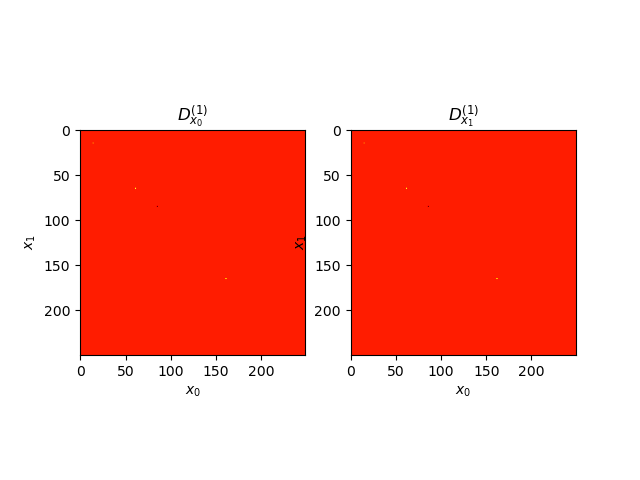

<IPython.core.display.Javascript object>


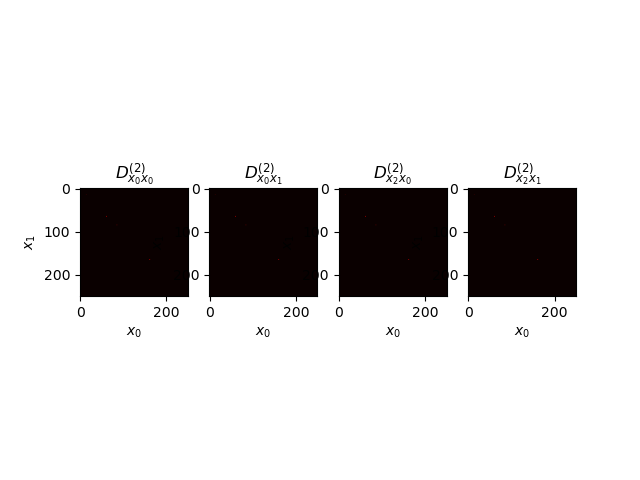

[<Figure size 640x480 with 2 Axes>, <Figure size 640x480 with 4 Axes>]

In [1722]:
analysis.visualize_2d(drift=analysis.drift(),diffusion=analysis.diffusion())

In [1726]:
analysis.recontruct(ivp=[1,2])

In [1729]:
plt.plot(analysis.recontruct())

ValueError: x, y, and format string must not be None

In [ ]:
def f(x, y):
    return x*y**2 - 5*x**3

x = np.linspace(-10,10,500)
y = np.linspace(-10,10,500)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)
#Z = 1/(1+np.exp(-X-Y))

fig = plt.figure()
ax = plt.axes(projection = '3d')
ax.plot_surface(X, Y, Z, cmap = 'gray', rstride=1, cstride=1)
ax.view_init(60, -100)

ax.set_axis_off()

plt.show()
#plt.savefig('demo.png', transparent=True)
